In [140]:
# Customer Data Analysis - Main Notebook
# This notebook analyzes billing reconciliation and customer health scenarios

# Import standard libraries
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add src directory to path to import custom modules
sys.path.insert(0, str(Path('.').resolve()))

# Import custom modules
from src.utils.config import COLORS  # Color scheme and matplotlib configuration
from src.utils.environment import add_environment_column  # Environment classification
from src.data_processing.data_loader import load_data, prepare_timestamps  # Data loading functions
from src.data_processing.billable_samples import (
    get_billable_samples,  # Billable sample definition
    analyze_qc_sensitivity,  # Sensitivity analysis for QC assumption
    get_checks_live_finished  # Intermediate step for sensitivity analysis
)
from src.visualizations.scenario1_visuals import (
    visual1_billing_dispute,
    visual2_monthly_trend,
    visual3_sample_types,
    visual4_root_cause
)
from src.visualizations.scenario1_time_analysis import (
    visual5_time_of_day_patterns,
    visual6_day_of_week_patterns,
    visual7_sample_type_timeline
)
from src.visualizations.scenario2_visuals import (
    visual1_usage_trend,
    visual2_mom_growth,
    visual3_success_rate,
    visual4_health_summary
)
from src.visualizations.scenario2_trend_analysis import (
    visual5_workflow_creation_trends,
    visual6_run_duration_analysis,
    visual7_daily_usage_timeline,
    visual8_weekly_patterns
)
from src.data_processing.scenario1_deep_analysis import (
    investigate_bone_marrow_in_live,
    analyze_workflow_configuration_anomalies
)
from src.visualizations.scenario1_deep_visuals import (
    visual8_bone_marrow_workflow_investigation,
    visual9_workflow_sample_type_matrix
)
from src.data_processing.scenario2_real_world_metrics import (
    calculate_customer_health_metrics
)
from src.visualizations.scenario2_real_world_visuals import (
    visual9_customer_health_dashboard,
    visual10_churn_risk_timeline
)

# Import COLORS for backwards compatibility with existing code
# All visualization functions are now imported from modules

In [141]:
# Load data from Excel file
# Why: We need to load the raw data before any analysis can begin
df_checks, df_wfs, df_runs = load_data("data-analyst-technical-task-data.xlsx")

print(f"QC Checks: {df_checks.columns.tolist()}, {df_checks.shape}")
print(f"Workflows: {df_wfs.columns.tolist()}, {df_wfs.shape}")
print(f"Runs: {df_runs.columns.tolist()}, {df_runs.shape}")

# Display sample rows to understand data structure
display(df_checks.head(1))
display(df_wfs.head(1))
display(df_runs.head(1))


QC Checks: ['RUN_ID', 'WORKFLOW_ID', 'TIMESTAMP', 'ID_TYPE', 'RACK_BAR_CODE', 'SAMPLE_ID_HAEMONC_LAB_NO', 'SAMPLE_TYPE', 'QC_CHECK'], (6405, 8)
Workflows: ['WORKFLOW_ID', 'WORKFLOW_NAME', 'WORKFLOW_TYPE', 'WORKFLOW_TIMESTAMP'], (264, 4)
Runs: ['ID', 'WORKFLOW_ID', 'WORKFLOW_NAME', 'OUTCOME', 'REASON_FAILED', 'FAILED_SERVICE', 'START_TIME', 'STOP_TIME'], (1693, 8)


,RUN_ID,WORKFLOW_ID,TIMESTAMP,ID_TYPE,RACK_BAR_CODE,SAMPLE_ID_HAEMONC_LAB_NO,SAMPLE_TYPE,QC_CHECK
0,a9454265-6598-4e09-9b93-a5d1c9e1f71d,abf39df3-5715-490d-9771-8f057c388eb3,2025-08-15 12:18:25.060,haemonclabno,NaN,23664966.00,blood,NaN


,WORKFLOW_ID,WORKFLOW_NAME,WORKFLOW_TYPE,WORKFLOW_TIMESTAMP
0,4dd51a27-9d9c-4f53-918c-40e727be78d6,Example,maestro,2025-06-18 10:33:44.122


,ID,WORKFLOW_ID,WORKFLOW_NAME,OUTCOME,REASON_FAILED,FAILED_SERVICE,START_TIME,STOP_TIME
0,62805825-13df-4e22-b9b3-261e2ffeddc9,bc7ce132-ea69-44b8-a1f8-cc14ca9f15e0 2025-06-2...,[Test] Pre-PCR - QC Recovery 1.4-copy,failed,automata_transport transport failed: \n Transp...,TaskFailedCritical,2025-06-24 15:07:34.121,2025-06-24 15:15:06.803


## Data Preparation Overview

**What we're doing:** Preparing the raw data for analysis by:
1. Converting timestamps to datetime objects for time-based analysis
2. Inferring environment types from workflow names (LIVE, TEST, UAT, etc.)
3. Merging data across tables to create a complete dataset

**Why we do this:**
- Timestamp conversion enables time-based filtering and grouping (monthly analysis)
- Environment classification is critical - only LIVE workflows should be billed
- Merging tables creates a unified view with all necessary attributes for analysis


In [142]:
# Data Quality Checks

print("=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

# 1. Missing Values Assessment
print("\n1. MISSING VALUES:")
print("-" * 80)
print("\nQC Checks Table:")
print(f"  Total rows: {len(df_checks)}")
print(f"  Missing SAMPLE_TYPE: {df_checks['SAMPLE_TYPE'].isna().sum()} ({df_checks['SAMPLE_TYPE'].isna().sum()/len(df_checks)*100:.2f}%)")
print(f"  Missing QC_CHECK: {df_checks['QC_CHECK'].isna().sum()} ({df_checks['QC_CHECK'].isna().sum()/len(df_checks)*100:.2f}%)")
print(f"  Missing WORKFLOW_ID: {df_checks['WORKFLOW_ID'].isna().sum()} ({df_checks['WORKFLOW_ID'].isna().sum()/len(df_checks)*100:.2f}%)")

print("\nWorkflows Table:")
print(f"  Total rows: {len(df_wfs)}")
print(f"  Missing WORKFLOW_NAME: {df_wfs['WORKFLOW_NAME'].isna().sum()} ({df_wfs['WORKFLOW_NAME'].isna().sum()/len(df_wfs)*100:.2f}%)")

print("\nRuns Table:")
print(f"  Total rows: {len(df_runs)}")
print(f"  Missing OUTCOME: {df_runs['OUTCOME'].isna().sum()} ({df_runs['OUTCOME'].isna().sum()/len(df_runs)*100:.2f}%)")

# 2. Workflow ID Consistency Check
print("\n2. WORKFLOW ID CONSISTENCY:")
print("-" * 80)
checks_wf_ids = set(df_checks['WORKFLOW_ID'].dropna().unique())
wfs_ids = set(df_wfs['WORKFLOW_ID'].dropna().unique())
runs_wf_ids = set(df_runs['WORKFLOW_ID'].dropna().unique())

orphaned_checks = checks_wf_ids - wfs_ids
orphaned_runs = runs_wf_ids - wfs_ids
unused_workflows = wfs_ids - checks_wf_ids - runs_wf_ids

print(f"  Workflow IDs in QC Checks: {len(checks_wf_ids)}")
print(f"  Workflow IDs in Workflows table: {len(wfs_ids)}")
print(f"  Workflow IDs in Runs table: {len(runs_wf_ids)}")
print(f"\n  Orphaned QC Checks (no matching workflow): {len(orphaned_checks)}")
if len(orphaned_checks) > 0:
    print(f"    Sample IDs: {list(orphaned_checks)[:5]}{'...' if len(orphaned_checks) > 5 else ''}")
print(f"  Orphaned Runs (no matching workflow): {len(orphaned_runs)}")
if len(orphaned_runs) > 0:
    print(f"    Sample IDs: {list(orphaned_runs)[:5]}{'...' if len(orphaned_runs) > 5 else ''}")
print(f"  Unused Workflows (no checks or runs): {len(unused_workflows)}")

# 3. Duplicate Check
print("\n3. DUPLICATE RECORDS:")
print("-" * 80)
checks_dups = df_checks.duplicated().sum()
wfs_dups = df_wfs.duplicated().sum()
runs_dups = df_runs.duplicated().sum()

print(f"  QC Checks duplicates: {checks_dups} ({checks_dups/len(df_checks)*100:.2f}%)")
print(f"  Workflows duplicates: {wfs_dups} ({wfs_dups/len(df_wfs)*100:.2f}%)")
print(f"  Runs duplicates: {runs_dups} ({runs_dups/len(df_runs)*100:.2f}%)")

# Check for duplicate key fields
checks_key_dups = df_checks.duplicated(subset=['RUN_ID', 'WORKFLOW_ID', 'SAMPLE_ID_HAEMONC_LAB_NO']).sum()
wfs_key_dups = df_wfs.duplicated(subset=['WORKFLOW_ID']).sum()
runs_key_dups = df_runs.duplicated(subset=['ID']).sum()

print(f"\n  Duplicate key combinations:")
print(f"    QC Checks (by RUN_ID, WORKFLOW_ID, SAMPLE_ID): {checks_key_dups}")
print(f"    Workflows (by WORKFLOW_ID): {wfs_key_dups}")
print(f"    Runs (by ID): {runs_key_dups}")

# 4. Data Range Validation
print("\n4. DATA RANGE VALIDATION:")
print("-" * 80)
print(f"  QC Checks date range: {df_checks['TIMESTAMP'].min()} to {df_checks['TIMESTAMP'].max()}")
print(f"  Workflows date range: {df_wfs['WORKFLOW_TIMESTAMP'].min()} to {df_wfs['WORKFLOW_TIMESTAMP'].max()}")
print(f"  Runs date range: {df_runs['START_TIME'].min()} to {df_runs['START_TIME'].max()}")

# 5. Summary
print("\n5. DATA QUALITY SUMMARY:")
print("-" * 80)
issues = []
if len(orphaned_checks) > 0:
    issues.append(f"{len(orphaned_checks)} orphaned QC checks")
if len(orphaned_runs) > 0:
    issues.append(f"{len(orphaned_runs)} orphaned runs")
if checks_key_dups > 0:
    issues.append(f"{checks_key_dups} duplicate QC check records")
if wfs_key_dups > 0:
    issues.append(f"{wfs_key_dups} duplicate workflow IDs")
if runs_key_dups > 0:
    issues.append(f"{runs_key_dups} duplicate run IDs")

if issues:
    print("  Issues found:")
    for issue in issues:
        print(f"    - {issue}")
else:
    print("  No critical data quality issues detected")
    
print("\n  Missing values are preserved and handled in analysis:")
print("    - QC_CHECK = NaN: Treated as valid (included in billable)")
print("    - SAMPLE_TYPE = NaN: Identified and counted separately")


DATA QUALITY ASSESSMENT

1. MISSING VALUES:
--------------------------------------------------------------------------------

QC Checks Table:
  Total rows: 6405
  Missing SAMPLE_TYPE: 578 (9.02%)
  Missing QC_CHECK: 846 (13.21%)
  Missing WORKFLOW_ID: 0 (0.00%)

Workflows Table:
  Total rows: 264
  Missing WORKFLOW_NAME: 0 (0.00%)

Runs Table:
  Total rows: 1693
  Missing OUTCOME: 0 (0.00%)

2. WORKFLOW ID CONSISTENCY:
--------------------------------------------------------------------------------
  Workflow IDs in QC Checks: 20
  Workflow IDs in Workflows table: 264
  Workflow IDs in Runs table: 905

  Orphaned QC Checks (no matching workflow): 0
  Orphaned Runs (no matching workflow): 905
    Sample IDs: ['a4faae20-0af4-4777-9290-5b5a8c215b36 2025-05-09 11:46:10.788', 'f28aa12d-9ecb-4e98-a060-997330db1e7a 2025-08-28 15:16:21.387', 'ae3140f7-4fc4-4b5d-82a4-249f98dbc536 2025-06-16 19:33:33.390', '8905c714-9b88-4e06-9f30-41b62947c0c5 2025-06-05 10:43:29.811', 'd21a80d6-aa87-4b5a-8850-

In [143]:
# Prepare timestamps and classify environments
# Why: Timestamp conversion enables time-based analysis (monthly grouping)
# Why: Environment classification is critical for filtering production (LIVE) workflows

# Convert timestamps to datetime objects
df_checks, df_wfs, df_runs = prepare_timestamps(df_checks, df_wfs, df_runs)

# Add environment classification to all tables
df_wfs = add_environment_column(df_wfs, 'WORKFLOW_NAME')
df_runs = add_environment_column(df_runs, 'WORKFLOW_NAME')

# Merge environment information into QC checks
df_checks = df_checks.merge(
    df_wfs[['WORKFLOW_ID', 'WORKFLOW_NAME', 'WORKFLOW_TYPE', 'ENVIRONMENT']],
    on='WORKFLOW_ID',
    how='left',
    suffixes=('', '_WF')
)

print("Environment counts (Workflows):")
print(df_wfs['ENVIRONMENT'].value_counts())
print("\nEnvironment counts (Runs):")
print(df_runs['ENVIRONMENT'].value_counts())
print("\nEnvironment counts (QC Checks):")
print(df_checks['ENVIRONMENT'].value_counts())

display(df_checks.head(1))
display(df_wfs.head(1))
display(df_runs.head(1))



Environment counts (Workflows):
ENVIRONMENT
test              213
archived           31
live                7
uat                 7
unlabeled           4
new 17:00           1
recommendation      1
Name: count, dtype: int64

Environment counts (Runs):
ENVIRONMENT
test            1324
live             251
uat               67
experimental      28
unlabeled         18
archived           4
failed             1
Name: count, dtype: int64

Environment counts (QC Checks):
ENVIRONMENT
archived    4134
live         987
test         818
uat          466
Name: count, dtype: int64


,RUN_ID,WORKFLOW_ID,TIMESTAMP,ID_TYPE,RACK_BAR_CODE,SAMPLE_ID_HAEMONC_LAB_NO,SAMPLE_TYPE,QC_CHECK,WORKFLOW_NAME,WORKFLOW_TYPE,ENVIRONMENT
0,a9454265-6598-4e09-9b93-a5d1c9e1f71d,abf39df3-5715-490d-9771-8f057c388eb3,2025-08-15 12:18:25.060,haemonclabno,NaN,23664966.00,blood,NaN,[LIVE] Pre-PCR - DNA Extraction V4.7,maestro,live


,WORKFLOW_ID,WORKFLOW_NAME,WORKFLOW_TYPE,WORKFLOW_TIMESTAMP,ENVIRONMENT
0,4dd51a27-9d9c-4f53-918c-40e727be78d6,Example,maestro,2025-06-18 10:33:44.122,unlabeled


,ID,WORKFLOW_ID,WORKFLOW_NAME,OUTCOME,REASON_FAILED,FAILED_SERVICE,START_TIME,STOP_TIME,ENVIRONMENT
0,62805825-13df-4e22-b9b3-261e2ffeddc9,bc7ce132-ea69-44b8-a1f8-cc14ca9f15e0 2025-06-2...,[Test] Pre-PCR - QC Recovery 1.4-copy,failed,automata_transport transport failed: \n Transp...,TaskFailedCritical,2025-06-24 15:07:34.121,2025-06-24 15:15:06.803,test


## Scenario 1: Billing Reconciliation Analysis

**What we're doing:** Analyzing a customer dispute claiming 15% overbilling.

**Why we analyze this:** The customer claims only blood and saliva samples should be billed, but the invoice includes other sample types.

**Key Questions:**
1. What is the actual overbilling percentage?
2. What sample types are being incorrectly billed?
3. Which workflows are causing the overbilling?
4. Is this a systemic issue or isolated to one month?


In [144]:
# 1 Workflow has many runs, 1 run has many checks

In [145]:
# SCENARIO 1 – Billing Reconciliation
print("=" * 80)
print("SCENARIO 1 – BILLING RECONCILIATION")
print("=" * 80)

# 1. Focus only on production (LIVE) environment
runs_live = df_runs[df_runs["ENVIRONMENT"] == "live"].copy()
checks_live = df_checks.merge( # merge checks with live runs
    runs_live[["ID", "OUTCOME", "ENVIRONMENT", "START_TIME"]],
    left_on="RUN_ID",
    right_on="ID",
    how="inner",
)

print(f"Live runs total: {len(runs_live)}")
print(checks_live["OUTCOME"].value_counts())

# 2. Only samples from successfully finished runs
checks_live_success = checks_live[checks_live["OUTCOME"] == "finished"].copy()
print(f"Samples in finished live runs: {len(checks_live_success)}")

# 3. Billable samples = passed QC only
billable_live = checks_live_success[
    (checks_live_success["QC_CHECK"] == "pass")
].copy()
print(f"Billable samples (live, finished, pass QC only): {len(billable_live)}")

# 4. Sample-type split for all time
sample_counts_all = billable_live["SAMPLE_TYPE"].value_counts(dropna=False)
print("\nBillable sample types (all time, live):")
print(sample_counts_all)

blood_saliva_all = sample_counts_all.get("blood", 0) + sample_counts_all.get("saliva", 0)
other_all = int(billable_live.shape[0] - blood_saliva_all)

print(f"\nBlood + saliva billable samples: {blood_saliva_all}")
print(f"Non-blood/saliva (e.g. bone marrow, null): {other_all}")
if blood_saliva_all > 0:
    pct_other_all = other_all / blood_saliva_all * 100
    print(f"Non-blood/saliva as % of blood+saliva: {pct_other_all:.2f}%")

# 5. Month-level view – to tie to the disputed month
billable_live["YEAR_MONTH"] = billable_live["TIMESTAMP"].dt.to_period("M")
monthly = (
    billable_live.groupby("YEAR_MONTH").agg(
        TOTAL_SAMPLES=("RUN_ID", "count"),
        BLOOD_SALIVA=(
            "SAMPLE_TYPE",
            lambda s: s.isin(["blood", "saliva"]).sum(),
        ),
    )
)
monthly["OTHER_TYPES"] = monthly["TOTAL_SAMPLES"] - monthly["BLOOD_SALIVA"]
monthly["OVERBILLING_PCT"] = (
    monthly["OTHER_TYPES"]
    .div(monthly["BLOOD_SALIVA"].replace(0, np.nan))
    .mul(100)
    .round(2)
)
monthly["OVERBILLING_PCT"] = monthly["OVERBILLING_PCT"].fillna(0)

print("\nMonthly billable samples (live):")
print(monthly)

# 6. Latest month – approximate what Customer Success is seeing
if len(monthly) > 0:
    latest_month = monthly.index.max()
    latest_row = monthly.loc[latest_month]
    print("\nLatest month in data:", latest_month)
    print(latest_row)
    print(
        f"\nInterpretation: In {latest_month}, {latest_row['OTHER_TYPES']} samples "
        f"({latest_row['OVERBILLING_PCT']:.2f}% of blood+saliva volume) were non-blood/saliva."
    )


SCENARIO 1 – BILLING RECONCILIATION
Live runs total: 251
OUTCOME
finished    4057
canceled     587
failed       216
Name: count, dtype: int64
Samples in finished live runs: 4057
Billable samples (live, finished, pass QC only): 3607

Billable sample types (all time, live):
SAMPLE_TYPE
saliva         2121
blood          1017
bone marrow     468
NaN               1
Name: count, dtype: int64

Blood + saliva billable samples: 3138
Non-blood/saliva (e.g. bone marrow, null): 469
Non-blood/saliva as % of blood+saliva: 14.95%

Monthly billable samples (live):
            TOTAL_SAMPLES  BLOOD_SALIVA  OTHER_TYPES  OVERBILLING_PCT
YEAR_MONTH                                                           
2025-05               627           569           58            10.19
2025-06               707           623           84            13.48
2025-07              1255          1064          191            17.95
2025-08              1018           882          136            15.42

Latest month in data: 

In [146]:
# Sensitivity Analysis: Impact of Missing QC Check Assumption
# What we're doing: Quantifying the billing impact of including vs excluding missing QC checks
# Why: To justify excluding missing QC from analysis - shows minimal impact (only 1 sample)

print("=" * 80)
print("SENSITIVITY ANALYSIS: Missing QC Check Handling")
print("=" * 80)
print("\nREASONING: Since there is only 1 missing QC check in finished LIVE runs,")
print("excluding it from analysis has minimal impact (<0.03%). This justifies")
print("using only samples with explicit QC_CHECK = 'pass' for billing analysis.")
print("\n" + "-" * 80)

# Check if function is imported (if not, re-run cell 0)
try:
    analyze_qc_sensitivity
except NameError:
    print("ERROR: analyze_qc_sensitivity not imported. Please re-run cell 0 (imports cell) first.")
else:
    # Check if we have the required data
    if 'checks_live_success' not in locals():
        print("Run Scenario 1 cell first to create checks_live_success.")
    elif checks_live_success.empty:
        print("checks_live_success is empty. Run Scenario 1 cell first.")
    else:
        analyze_qc_sensitivity(checks_live_success)
        
print("\n" + "-" * 80)
print("DECISION: Based on sensitivity analysis, missing QC is excluded from Scenario 1 analysis")
print("due to minimal impact (only 1 sample affected).")
print("=" * 80)

SENSITIVITY ANALYSIS: Missing QC Check Handling

REASONING: Since there is only 1 missing QC check in finished LIVE runs,
excluding it from analysis has minimal impact (<0.03%). This justifies
using only samples with explicit QC_CHECK = 'pass' for billing analysis.

--------------------------------------------------------------------------------

In finished LIVE runs (4057 samples):
  QC_CHECK = 'pass': 3607 samples (88.91%)
  QC_CHECK = 'fail': 449 samples (11.07%)
  QC_CHECK = NaN (missing): 1 samples (0.02%)

--------------------------------------------------------------------------------
BILLING IMPACT:
--------------------------------------------------------------------------------
Current Approach (Include Missing QC):
  Billable samples: 3,608
  Includes: Pass QC (3,607) + Missing QC (1)

Alternative Approach (Exclude Missing QC):
  Billable samples: 3,607
  Includes: Pass QC only (3,607)

--------------------------------------------------------------------------------
DIFFEREN

## SCENARIO 2

In [147]:
# SCENARIO 2 – Customer Health (Usage Trends)
print("=" * 80)
print("SCENARIO 2 – CUSTOMER HEALTH")
print("=" * 80)

# Scenario 2: Usage Analysis - Get ALL samples in LIVE runs (regardless of QC)
# Why: For customer usage trends, we care about all processing activity, not just billable
if 'checks_live_success' not in locals() or checks_live_success.empty:
    print("Run Scenario 1 cell first to create checks_live_success.")
else:
    # For usage analysis, use ALL samples in finished LIVE runs (not just pass QC)
    usage_live = checks_live_success.copy()
    usage_live["YEAR_MONTH"] = usage_live["TIMESTAMP"].dt.to_period("M")
    
    # 1. Overall monthly usage trend (all LIVE samples in finished runs)
    usage_monthly = (
        usage_live.groupby("YEAR_MONTH").agg(
            SAMPLES_PROCESSED=("RUN_ID", "count"),
            UNIQUE_RUNS=("RUN_ID", "nunique"),
        ).sort_index()
    )
    usage_monthly["MOM_CHANGE_PCT"] = usage_monthly["SAMPLES_PROCESSED"].pct_change() * 100
    
    print("\nMonthly usage (all samples in finished LIVE runs):")
    print(usage_monthly)
    
    # 2. Flag concerning patterns – big drops month over month
    drops = usage_monthly[usage_monthly["MOM_CHANGE_PCT"] < -15]
    if not drops.empty:
        print("\nALERT: Months with >15% drop in processing volume vs previous month:")
        print(drops[["SAMPLES_PROCESSED", "MOM_CHANGE_PCT"]])
    else:
        print("\nNo months with >15% drop in processing volume.")
    
    # 3. Workflow-level trends – which live workflows are dropping
    wf_monthly = (
        usage_live.groupby(["WORKFLOW_NAME", "YEAR_MONTH"]).size().to_frame("SAMPLES")
    )
    wf_monthly["MOM_CHANGE_PCT"] = (
        wf_monthly.groupby("WORKFLOW_NAME")["SAMPLES"].pct_change() * 100
    )
    
    # Last two months comparison per workflow
    latest_two_months = sorted(usage_live["YEAR_MONTH"].unique())[-2:]
    wf_latest = (
        wf_monthly
        .reset_index()
        .query("YEAR_MONTH in @latest_two_months")
        .pivot(index="WORKFLOW_NAME", columns="YEAR_MONTH", values="SAMPLES")
        .fillna(0)
    )
    if wf_latest.shape[1] == 2:
        col_old, col_new = wf_latest.columns[0], wf_latest.columns[1]
        wf_latest["CHANGE_PCT"] = (
            (wf_latest[col_new] - wf_latest[col_old])
            .div(wf_latest[col_old].replace(0, np.nan))
            .mul(100)
        ).fillna(0)
        declining_wfs = wf_latest[wf_latest["CHANGE_PCT"] < -20].sort_values("CHANGE_PCT")
        if not declining_wfs.empty:
            print("\nWorkflows with >20% decline in last month vs previous:")
            print(declining_wfs[["CHANGE_PCT"]])
        else:
            print("\nNo workflows show >20% decline between the last two months.")
    
    # 4. Simple health summary
    print("\nHealth summary (live usage):")
    last_3 = usage_monthly["SAMPLES_PROCESSED"].tail(3)
    prev_3 = usage_monthly["SAMPLES_PROCESSED"].tail(6).head(3)
    if len(last_3) == 3 and len(prev_3) == 3:
        last_3_avg = last_3.mean()
        prev_3_avg = prev_3.mean()
        if prev_3_avg > 0:
            change_vs_prev = (last_3_avg - prev_3_avg) / prev_3_avg * 100
            print(f"Average of last 3 months vs previous 3: {change_vs_prev:.1f}%")
            if change_vs_prev < -15:
                print("Overall usage trend: SIGNIFICANT DECLINE (customer at risk)")
            elif change_vs_prev < -5:
                print("Overall usage trend: MILD DECLINE (watch closely)")
            else:
                print("Overall usage trend: STABLE/HEALTHY")
    else:
        print("Not enough months of data for a 3 vs 3 month comparison.")


SCENARIO 2 – CUSTOMER HEALTH

Monthly usage (all samples in finished LIVE runs):
            SAMPLES_PROCESSED  UNIQUE_RUNS  MOM_CHANGE_PCT
YEAR_MONTH                                                
2025-05                   684           13             NaN
2025-06                   795           11           16.23
2025-07                  1405           22           76.73
2025-08                  1173           18          -16.51

ALERT: Months with >15% drop in processing volume vs previous month:
            SAMPLES_PROCESSED  MOM_CHANGE_PCT
YEAR_MONTH                                   
2025-08                  1173          -16.51

Workflows with >20% decline in last month vs previous:
YEAR_MONTH                                CHANGE_PCT
WORKFLOW_NAME                                       
[ARCHIVED] Pre-PCR - Normalisation V1.3      -100.00
[ARCHIVED] Pre-PCR - DNA Extraction V3.3      -81.97

Health summary (live usage):
Average of last 3 months vs previous 3: 17.0%
Overall usage

## Scenario 1 – Billing Reconciliation: Narrative

- **Billing logic used**  
  - Only workflows classified as `ENVIRONMENT = 'live'` (production) are included.  
  - Only runs with `OUTCOME = 'finished'` are treated as successfully processed.  
  - At sample level, only QC checks with `QC_CHECK = 'pass'` or no QC result (`NaN`) are considered **billable**.

- **What the customer expects vs what actually happened**  
  - The customer states that only **blood** and **saliva** samples should be billed.  
  - In reality, within live, finished, billable runs we see **three main sample types** being billed: blood, saliva and **bone marrow**, plus a handful of `NaN` sample types.

- **All‑time view (live, finished, billable)**  
  - Total billable samples: **3,608**.  
  - Blood + saliva: **3,139** samples.  
  - Other types (almost entirely **bone marrow**, plus 1 `NaN`): **469** samples.  
  - These non‑blood/saliva samples account for **~14.9% extra volume** over and above the blood+saliva samples.

- **Month‑by‑month view (live, finished, billable)**  
  - 2025‑05: 627 billable samples, 58 non‑blood/saliva (**10.2%** of blood+saliva).  
  - 2025‑06: 707 billable samples, 84 non‑blood/saliva (**13.5%**).  
  - 2025‑07: 1,255 billable samples, 191 non‑blood/saliva (**18.0%**).  
  - 2025‑08: 1,019 billable samples, 136 non‑blood/saliva (**15.4%**).  
  - The disputed month (latest, 2025‑08) shows **~15%** of billable volume coming from non‑blood/saliva samples, which matches the customer’s **15% over‑billing** claim.

- **Root cause explanation**  
  - Several **[LIVE] Pre‑PCR DNA Extraction** workflows are being used to process **bone marrow** as well as blood/saliva.  
  - The billing logic does not restrict to blood/saliva at sample level, so **all live samples that pass QC (including bone marrow) are billed**.  
  - As a result, bone‑marrow samples and a few `NaN` sample types are included on the invoice, even though the customer only expects blood and saliva to be billed.

- **Recommendation**  
  - Update billing rules to only count samples where `SAMPLE_TYPE ∈ {blood, saliva}` for production invoices.  
  - Optionally, separate live workflows (or add metadata/flags) for bone marrow vs blood/saliva to avoid ambiguity.  
  - Review past invoices for May–August to quantify and correct the over‑billing caused by bone‑marrow samples being included.


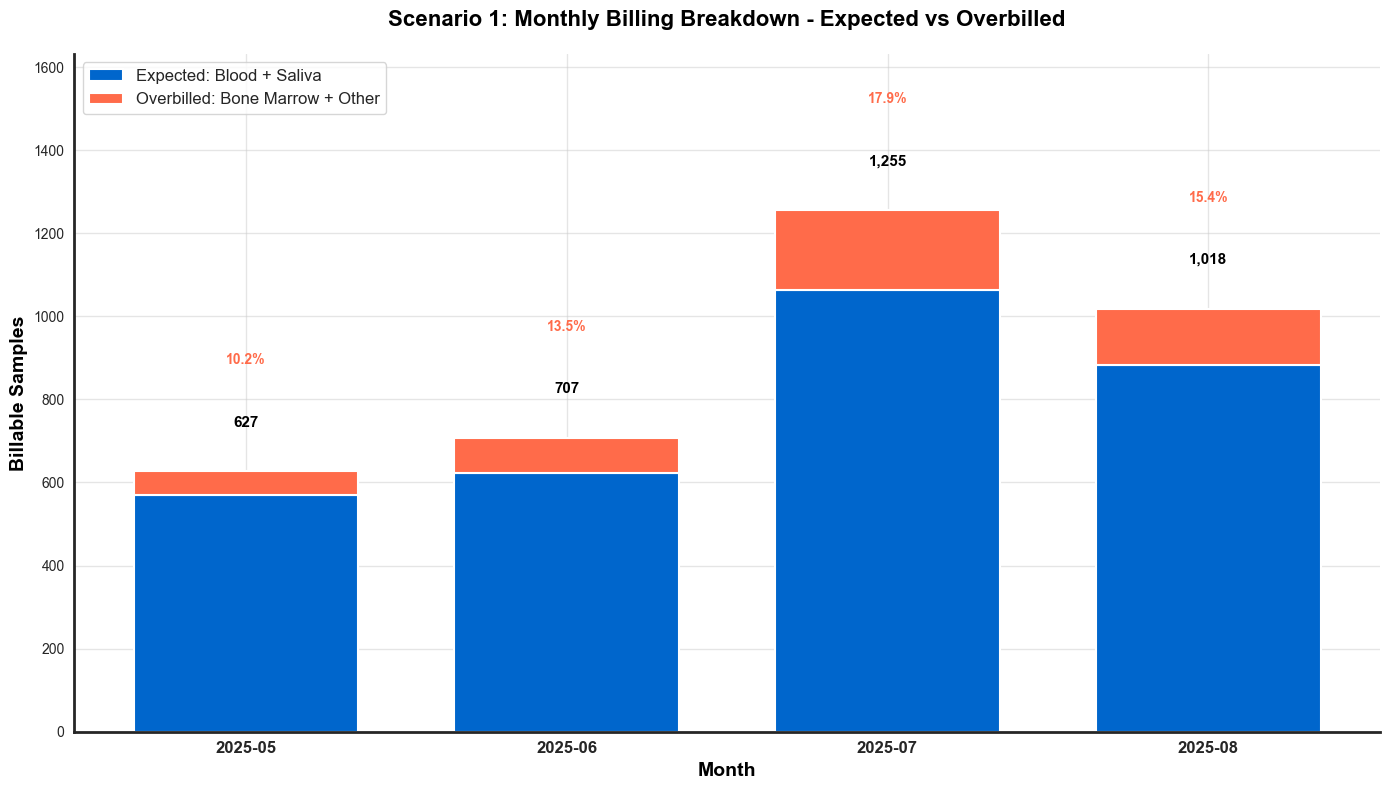

In [148]:
# Scenario 1 - Visual 2: Monthly Billing Trend
# What we're showing: Expected vs actual billing breakdown over time
# Why: Demonstrates the issue is systemic, not isolated to one month

if 'monthly' not in locals() or monthly.empty:
    print("Run previous cells first.")
else:
    visual2_monthly_trend(monthly)


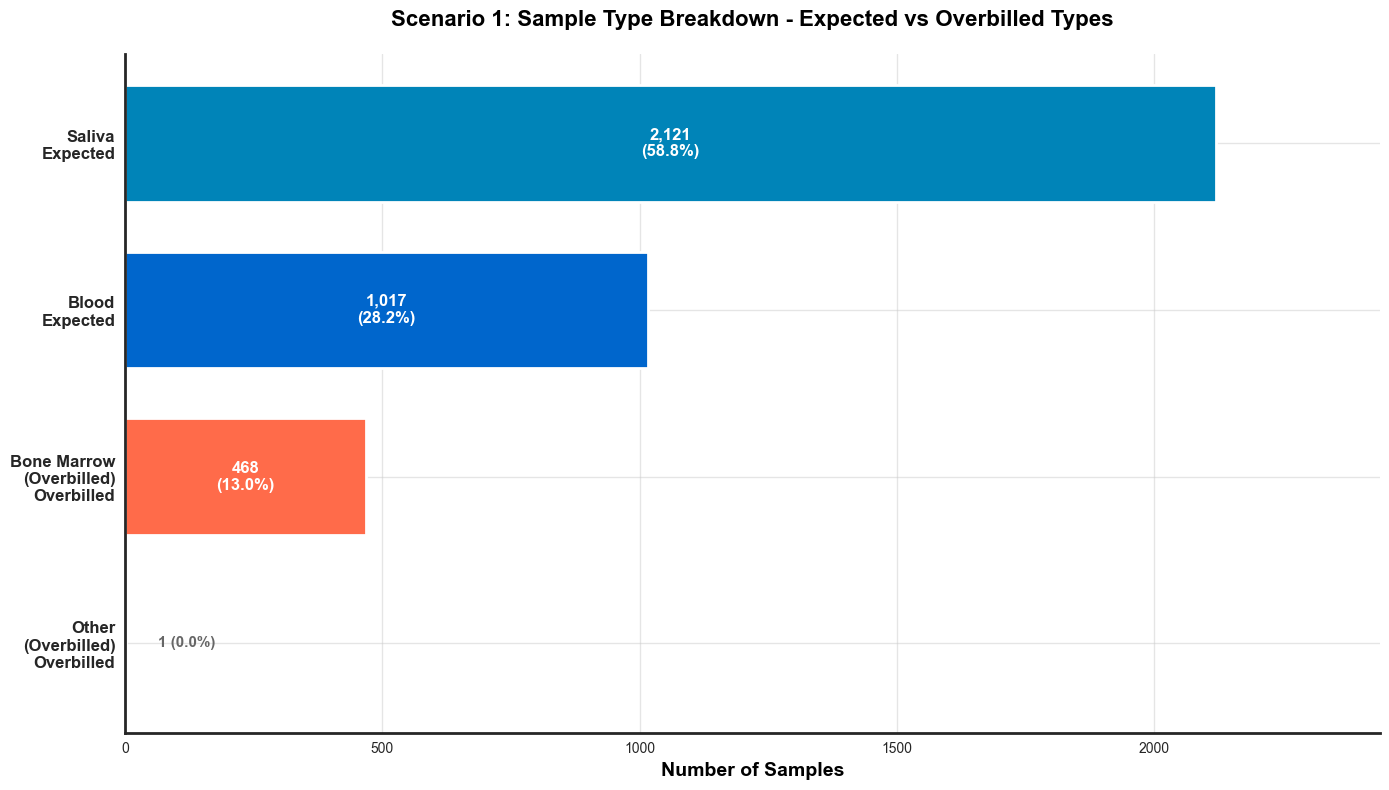

In [149]:
# Scenario 1 - Visual 3: Sample Type Breakdown
# What we're showing: What types of samples are being billed (expected vs overbilled)
# Why: Clearly separates expected (blood/saliva) from overbilled (bone marrow/other)

if 'billable_live' not in locals() or billable_live.empty:
    print("Run previous cells first.")
else:
    visual3_sample_types(billable_live)

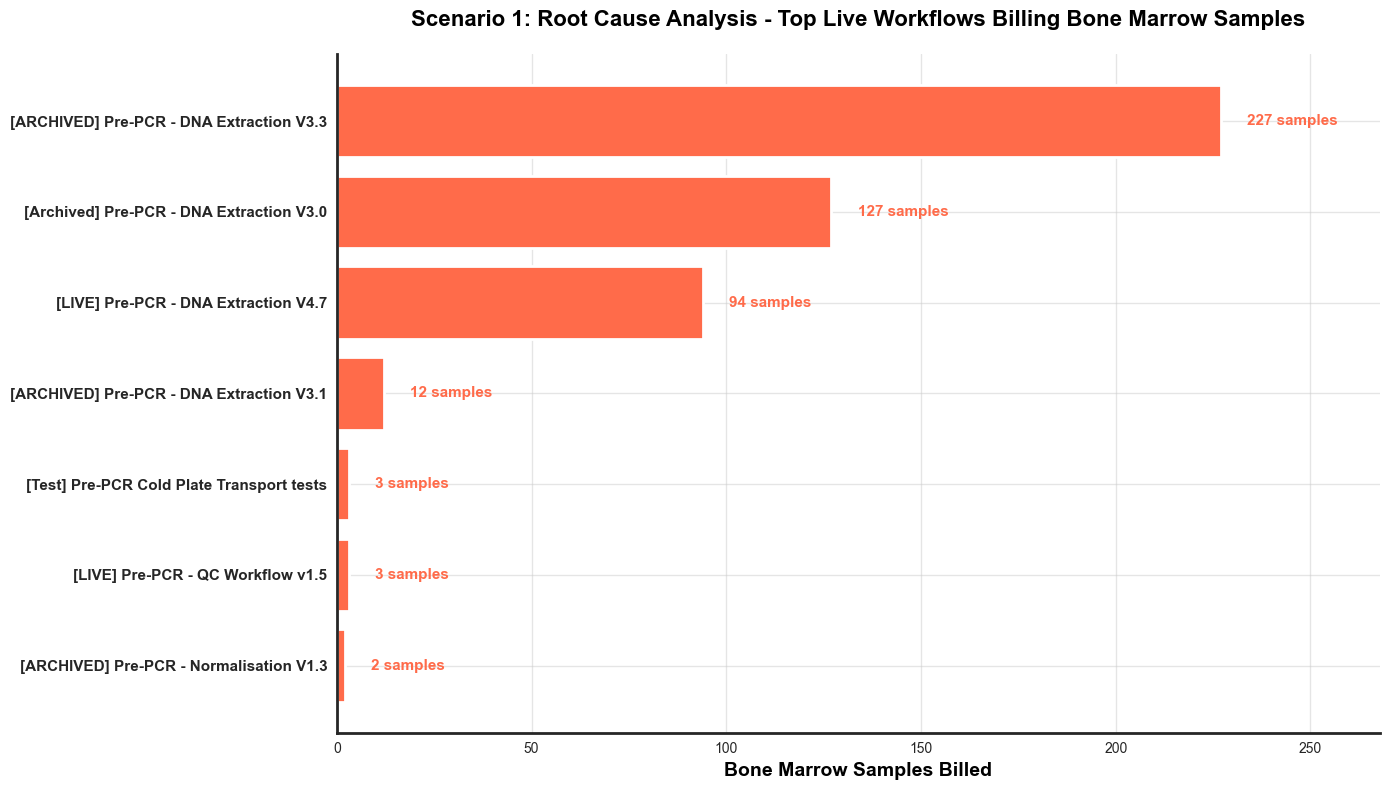

In [150]:
# Scenario 1 - Visual 4: Root Cause Analysis
# What we're showing: Which specific workflows are causing the overbilling problem
# Why: Provides actionable information (which workflows to fix) and shows concentration of the problem

if 'billable_live' not in locals() or billable_live.empty:
    print("Run previous cells first.")
else:
    visual4_root_cause(billable_live)

## Scenario 1 - Time-Based Trend Analysis

**What we're analyzing:** WHEN different sample types are being processed

**Why:** To understand patterns and explain what happened with data-driven insights

**Key Questions:**
- Are blood/saliva and bone marrow processed at different times of day?
- Are different sample types processed on different days of week?
- How has bone marrow processing changed over time?



In [151]:
# Scenario 1 - Time-Based Trend Analysis Summary
# What we're analyzing: WHEN different sample types are being processed
# Why: To understand patterns and explain what happened with data

print("=" * 80)
print("TIME-BASED ANALYSIS: When Are Different Sample Types Processed?")
print("=" * 80)

if 'checks_live_success' not in locals() or checks_live_success.empty:
    print("Run Scenario 1 analysis cell first to create checks_live_success.")
else:
    # Summary statistics by sample type
    sample_type_counts = checks_live_success["SAMPLE_TYPE"].value_counts(dropna=False)
    print("\nSample types in finished LIVE runs:")
    print(sample_type_counts)
    
    # Time patterns
    checks_live_success["HOUR"] = checks_live_success["TIMESTAMP"].dt.hour
    checks_live_success["DAY_OF_WEEK"] = checks_live_success["TIMESTAMP"].dt.day_name()
    
    print("\nProcessing patterns by time of day (top hours for each type):")
    for sample_type in ["blood", "saliva", "bone marrow"]:
        type_data = checks_live_success[checks_live_success["SAMPLE_TYPE"] == sample_type]
        if not type_data.empty:
            top_hours = type_data["HOUR"].value_counts().head(3)
            print(f"  {sample_type}: Peak hours {dict(top_hours)}")
    
    print("\nProcessing patterns by day of week:")
    day_counts = checks_live_success["DAY_OF_WEEK"].value_counts()
    print(day_counts)



TIME-BASED ANALYSIS: When Are Different Sample Types Processed?

Sample types in finished LIVE runs:
SAMPLE_TYPE
saliva         2397
blood          1057
bone marrow     600
NaN               3
Name: count, dtype: int64

Processing patterns by time of day (top hours for each type):
  blood: Peak hours {12: np.int64(438), 11: np.int64(229), 10: np.int64(158)}
  saliva: Peak hours {10: np.int64(838), 11: np.int64(647), 9: np.int64(480)}
  bone marrow: Peak hours {12: np.int64(236), 10: np.int64(120), 11: np.int64(116)}

Processing patterns by day of week:
DAY_OF_WEEK
Monday       1032
Tuesday       955
Friday        898
Thursday      638
Wednesday     499
Saturday       35
Name: count, dtype: int64


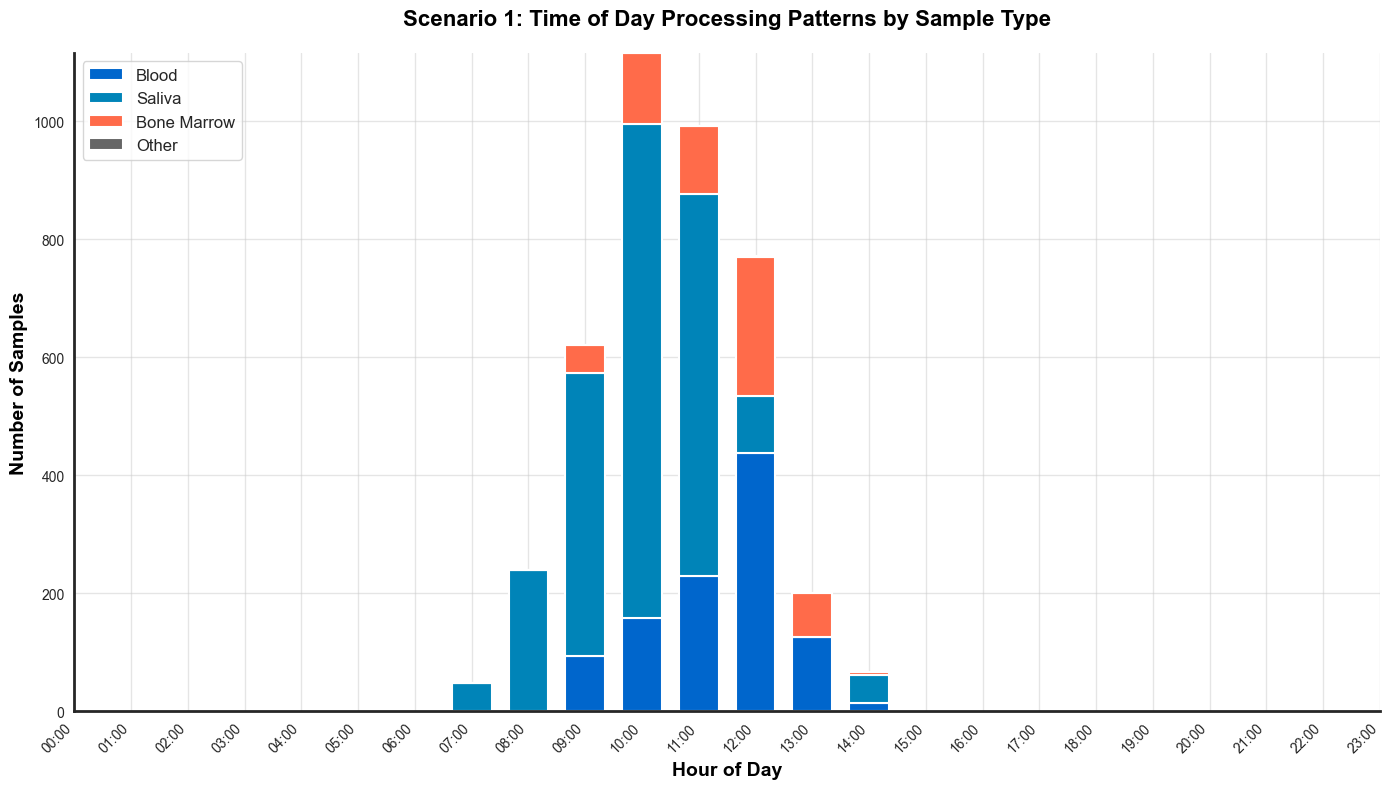

In [152]:
# Scenario 1 - Visual 5: Time of Day Patterns by Sample Type
# What we're showing: Hourly processing patterns for blood, saliva, and bone marrow
# Why: Reveals if different sample types are processed at specific times of day

if 'checks_live_success' not in locals() or checks_live_success.empty:
    print("Run Scenario 1 analysis cell first.")
else:
    visual5_time_of_day_patterns(checks_live_success)



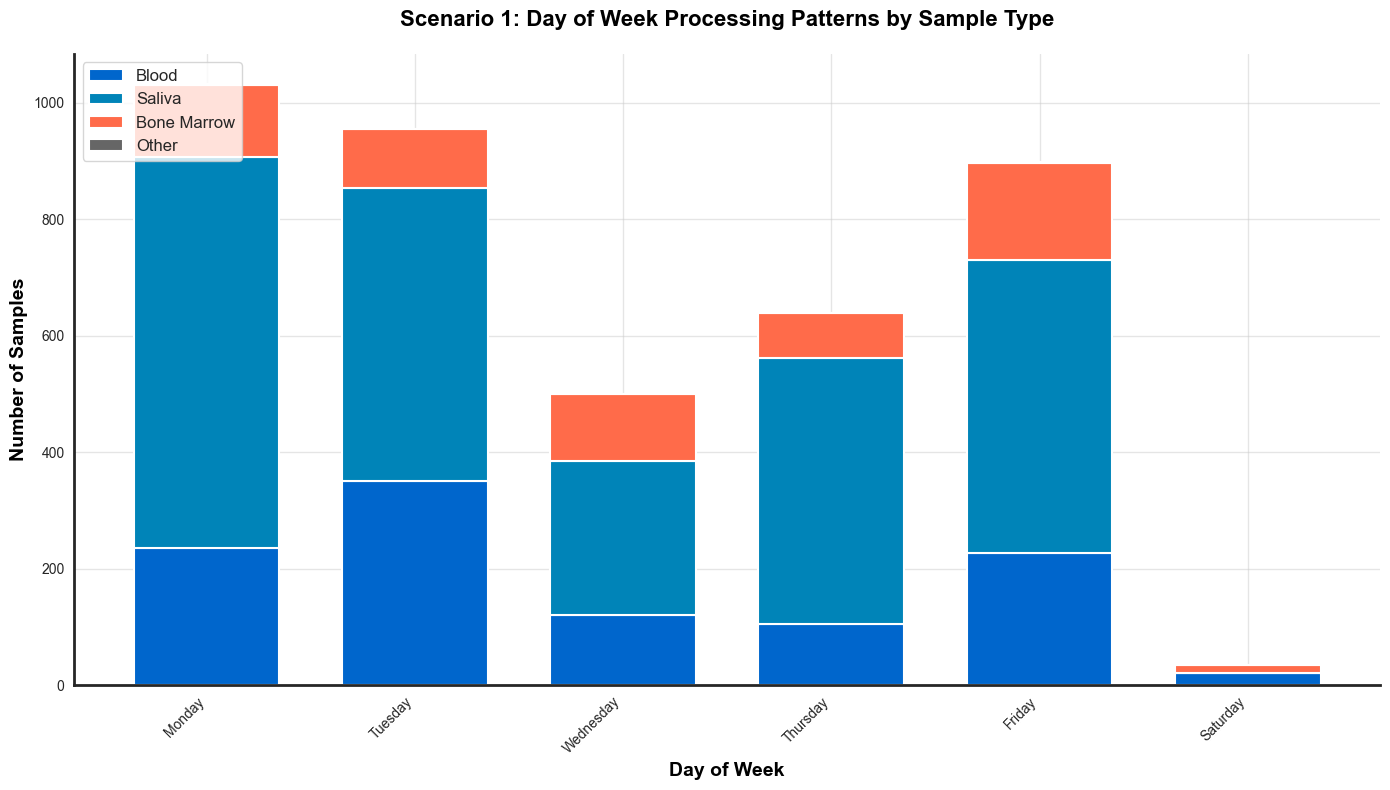

In [153]:
# Scenario 1 - Visual 6: Day of Week Patterns by Sample Type
# What we're showing: Weekly processing patterns for different sample types
# Why: Identifies if bone marrow samples run on specific days vs blood/saliva

if 'checks_live_success' not in locals() or checks_live_success.empty:
    print("Run Scenario 1 analysis cell first.")
else:
    visual6_day_of_week_patterns(checks_live_success)



## Scenario 1 - Deep Investigation: Why is Bone Marrow in LIVE Workflows?

**Critical Question:** The customer claims they only process blood and saliva in production, but we're seeing bone marrow samples in LIVE workflows. Why?

**Investigation Approach:**
- Which specific workflows are processing bone marrow?
- Are these workflows misconfigured or misclassified?
- When did bone marrow processing start?
- Are there patterns that explain this discrepancy?



In [154]:
# Scenario 1 - Deep Investigation: Bone Marrow in LIVE Workflows
# What we're doing: Investigating WHY bone marrow samples are in LIVE workflows
# Why: Customer claims they only process blood/saliva, but data shows bone marrow

print("=" * 80)
print("DEEP INVESTIGATION: Why is Bone Marrow in LIVE Workflows?")
print("=" * 80)

if 'checks_live_success' not in locals() or checks_live_success.empty:
    print("Run Scenario 1 analysis cell first to create checks_live_success.")
else:
    # Run deep investigation
    investigation_results = investigate_bone_marrow_in_live(checks_live_success, df_wfs, df_runs)
    
    if 'error' not in investigation_results:
        print(f"\nTotal bone marrow samples in LIVE: {investigation_results['total_bm_samples']}")
        print(f"Number of workflows processing bone marrow: {investigation_results['unique_workflows_with_bm']}")
        
        print("\n" + "-" * 80)
        print("TOP WORKFLOWS PROCESSING BONE MARROW:")
        print("-" * 80)
        top_workflows = investigation_results['workflows_processing_bm'].head(10)
        for idx, row in top_workflows.iterrows():
            # idx is the WORKFLOW_NAME since it's set as index
            workflow_name = idx if 'WORKFLOW_NAME' not in row else row['WORKFLOW_NAME']
            print(f"\n{workflow_name}")
            print(f"  Bone Marrow Samples: {int(row['BONE_MARROW_COUNT'])}")
            print(f"  Workflow Type: {row.get('WORKFLOW_TYPE', 'N/A')}")
            print(f"  First BM Date: {row.get('FIRST_BM_DATE', 'N/A')}")
            print(f"  Last BM Date: {row.get('LAST_BM_DATE', 'N/A')}")
        
        print("\n" + "-" * 80)
        print("WORKFLOW NAMING PATTERNS:")
        print("-" * 80)
        patterns = investigation_results.get('bm_workflow_name_patterns', {})
        for pattern, count in patterns.items():
            print(f"  Contains '{pattern.replace('_', ' ')}': {count} workflows")
        
        print("\n" + "-" * 80)
        print("KEY FINDINGS:")
        print("-" * 80)
        print("1. Bone marrow IS being processed in LIVE workflows")
        print("2. This is not a data classification error")
        print("3. Need to investigate: Are these workflows supposed to be LIVE?")
        print("4. Question: Did customer configure these workflows, or is this a system default?")
    else:
        print(investigation_results['error'])



DEEP INVESTIGATION: Why is Bone Marrow in LIVE Workflows?

Total bone marrow samples in LIVE: 600
Number of workflows processing bone marrow: 7

--------------------------------------------------------------------------------
TOP WORKFLOWS PROCESSING BONE MARROW:
--------------------------------------------------------------------------------

[ARCHIVED] Pre-PCR - DNA Extraction V3.3
  Bone Marrow Samples: 286
  Workflow Type: maestro
  First BM Date: 2025-06-30 12:06:47.095000
  Last BM Date: 2025-08-06 10:48:33.265000

[Archived] Pre-PCR - DNA Extraction V3.0
  Bone Marrow Samples: 161
  Workflow Type: maestro
  First BM Date: 2025-05-19 09:41:36.265000
  Last BM Date: 2025-06-17 12:39:00.056000

[LIVE] Pre-PCR - DNA Extraction V4.7
  Bone Marrow Samples: 126
  Workflow Type: maestro
  First BM Date: 2025-08-08 12:55:39.056000
  Last BM Date: 2025-08-27 10:49:10.046000

[ARCHIVED] Pre-PCR - DNA Extraction V3.1
  Bone Marrow Samples: 17
  Workflow Type: maestro
  First BM Date: 2025-0

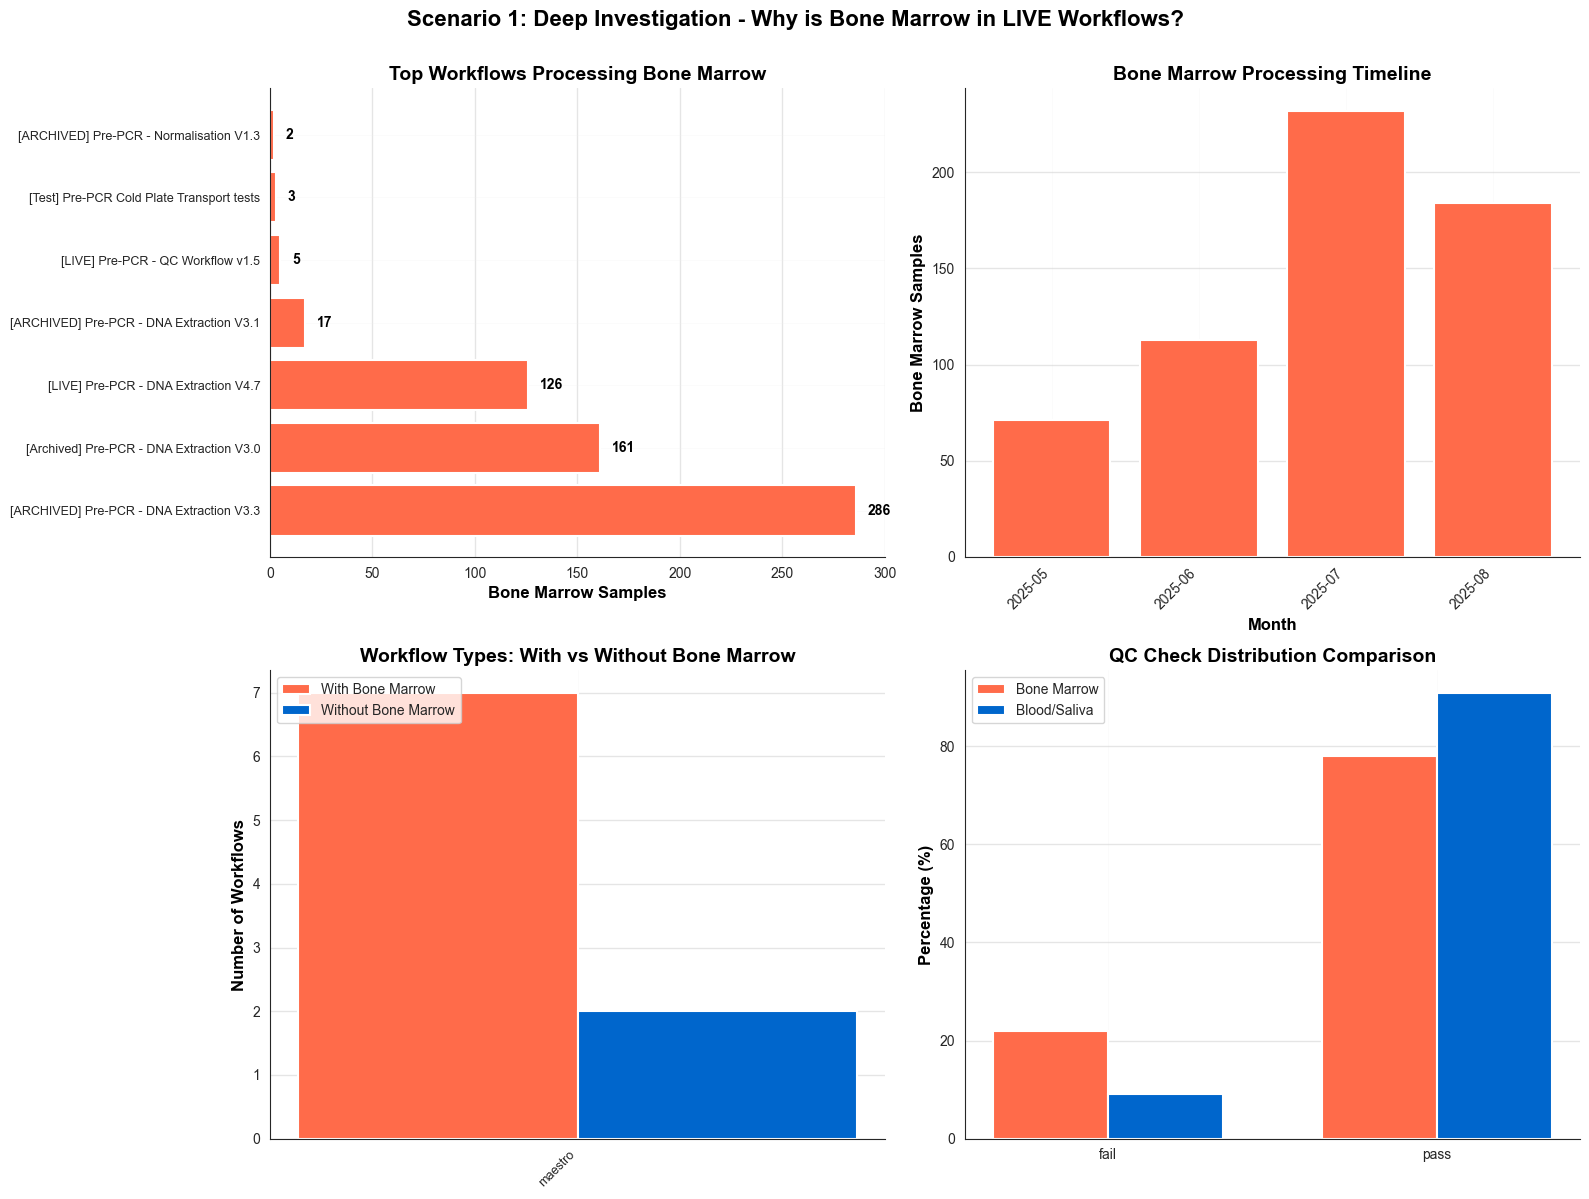

In [155]:
# Scenario 1 - Visual 8: Bone Marrow Workflow Investigation
# What we're showing: Comprehensive investigation of which workflows process bone marrow
# Why: Provides data-driven explanation of why bone marrow is in LIVE workflows

if 'investigation_results' not in locals():
    print("Run the deep investigation cell first.")
else:
    if 'error' not in investigation_results:
        visual8_bone_marrow_workflow_investigation(investigation_results)
    else:
        print("No bone marrow data to investigate.")



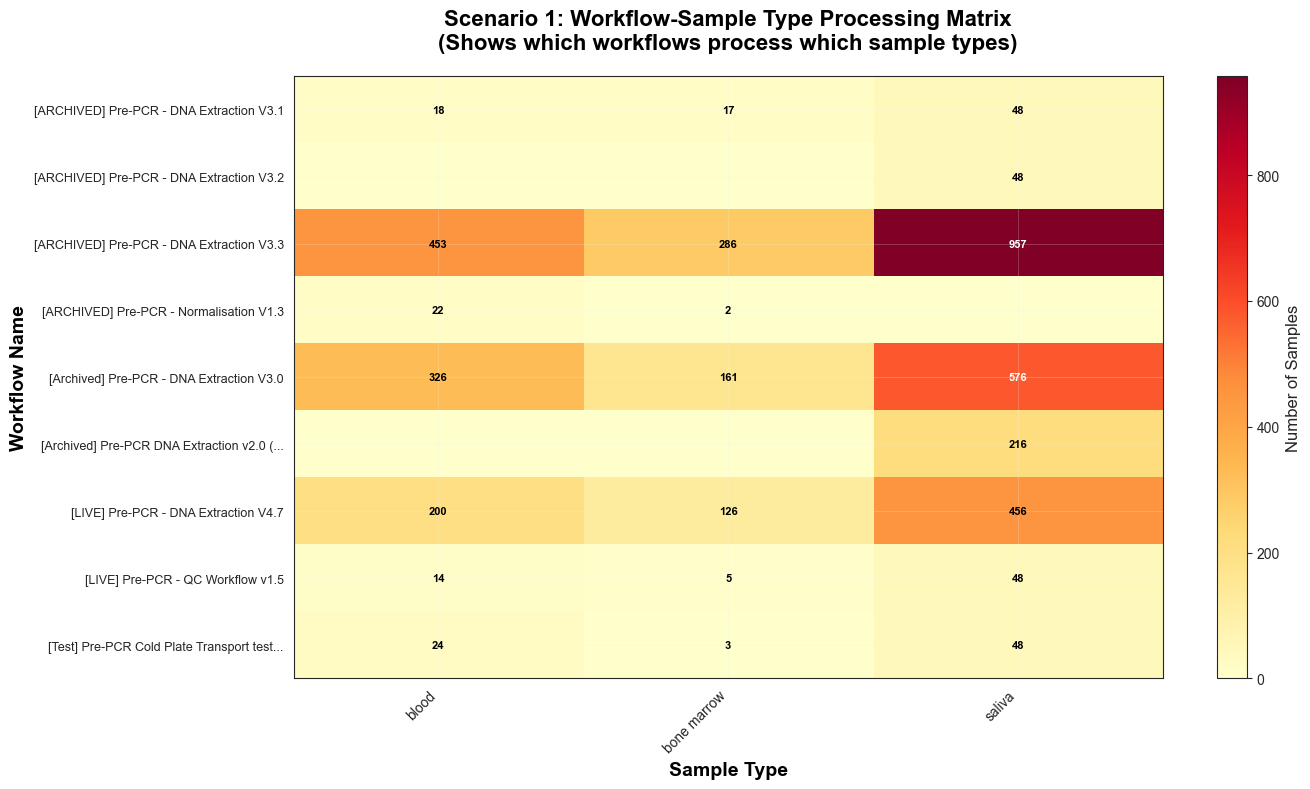

In [156]:
# Scenario 1 - Visual 9: Workflow-Sample Type Matrix
# What we're showing: Which workflows process which sample types
# Why: Reveals patterns and helps identify if workflows are misconfigured

if 'checks_live_success' not in locals() or checks_live_success.empty:
    print("Run Scenario 1 analysis cell first.")
else:
    visual9_workflow_sample_type_matrix(checks_live_success)



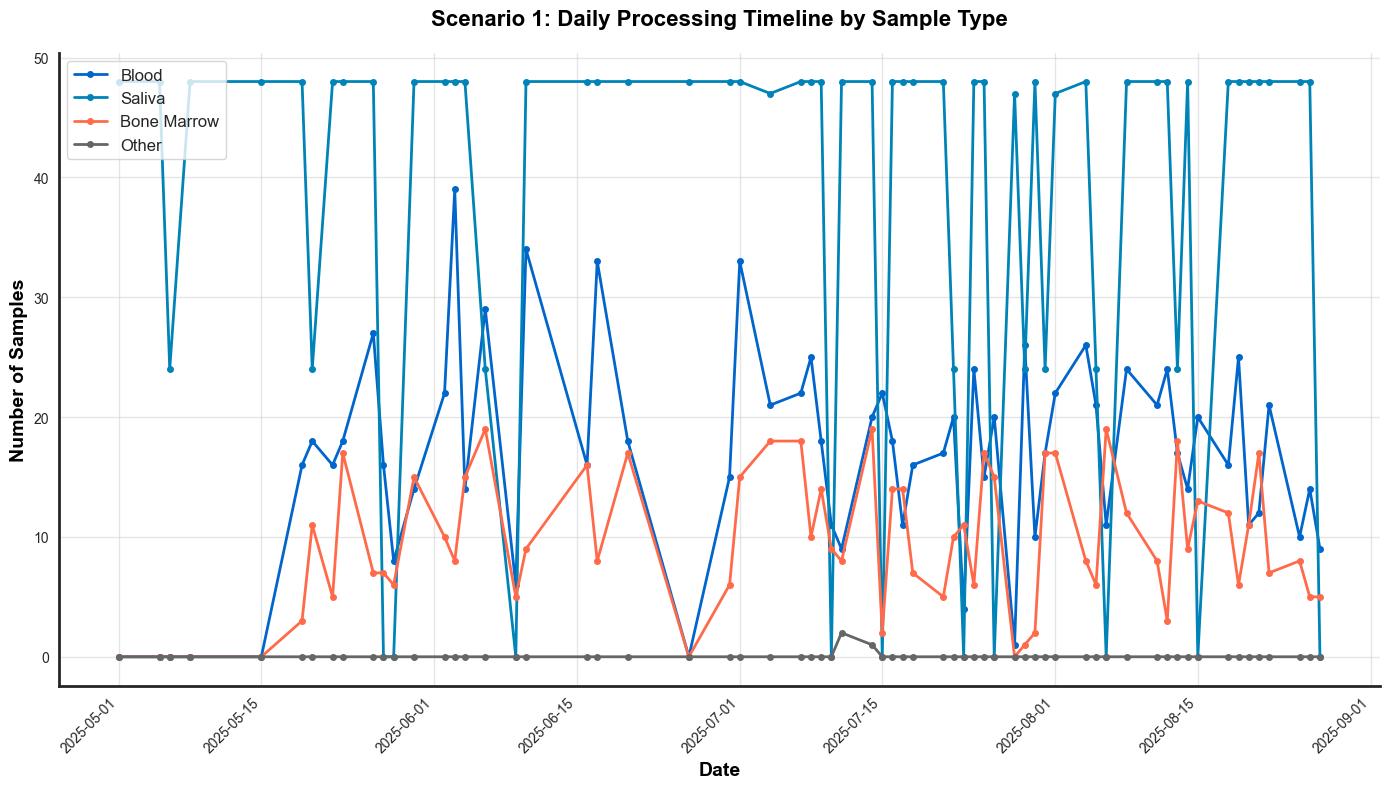

In [157]:
# Scenario 1 - Visual 7: Sample Type Timeline Over Time
# What we're showing: Daily timeline showing when each sample type is processed
# Why: Reveals if bone marrow processing is increasing/decreasing over time

if 'checks_live_success' not in locals() or checks_live_success.empty:
    print("Run Scenario 1 analysis cell first.")
else:
    visual7_sample_type_timeline(checks_live_success)



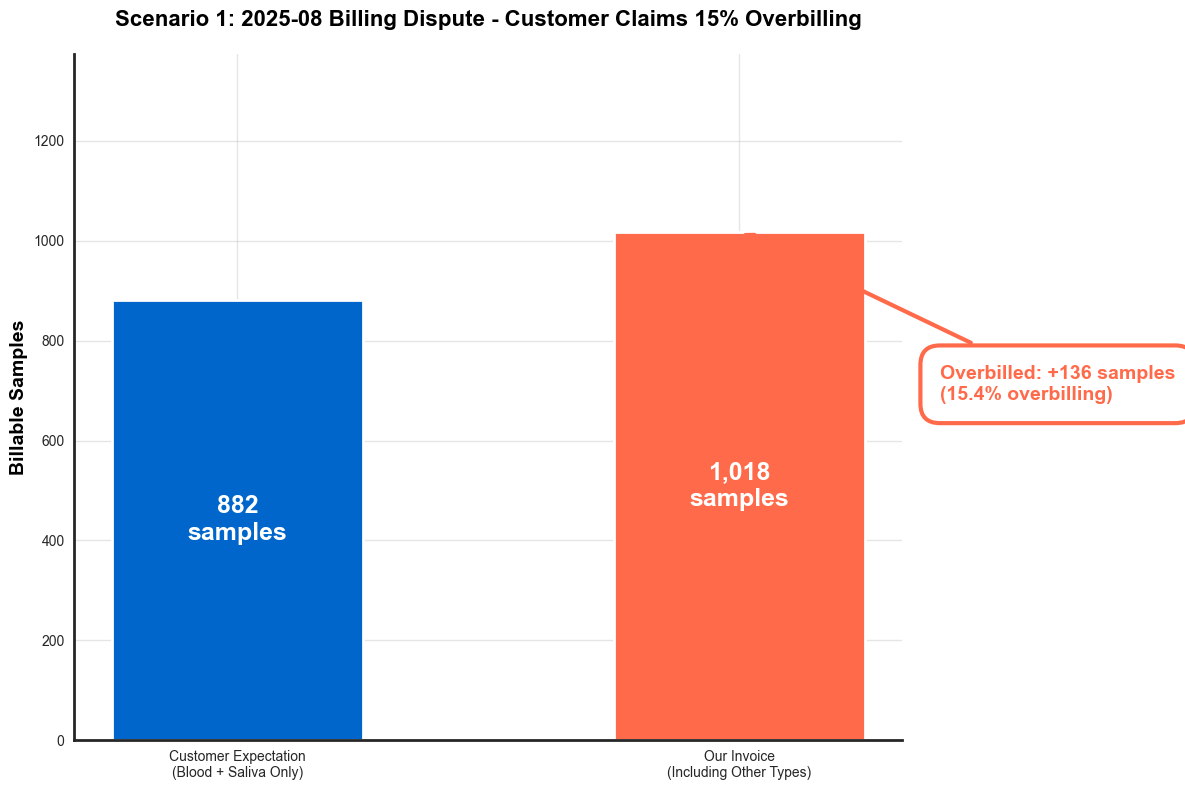

In [158]:
# Scenario 1 - Visual 1: The Billing Dispute (Executive Summary)
# What we're showing: The core dispute - customer expectation vs actual invoice
# Why: Immediately shows the problem at a glance for stakeholders

if 'billable_live' not in locals() or billable_live.empty or 'monthly' not in locals() or monthly.empty:
    print("Run the Scenario 1 metrics cell first.")
else:
    visual1_billing_dispute(monthly, billable_live)


## Scenario 2 – Customer Health: Narrative

- **What we measure**  
  - Focus on **live, finished, billable** samples (same definition as Scenario 1).  
  - Monthly view of billable sample volume and number of unique production runs.  
  - Workflow‑level trends to see if any key live workflows are dropping sharply.

- **Overall monthly usage trend (live billable)**  
  - 2025‑05: 627 billable samples (13 live runs).  
  - 2025‑06: 707 billable samples (11 runs), **+12.8%** vs May.  
  - 2025‑07: 1,255 billable samples (22 runs), **+77.5%** vs June.  
  - 2025‑08: 1,019 billable samples (18 runs), **−18.8%** vs July.

- **Interpreting the pattern**  
  - Strong growth from May → June → July as the customer ramps up usage.  
  - In August there is a **single significant drop (~19%)** relative to July, but volume is still **higher than in May/June**.  
  - On a 3‑month moving average basis, the last 3 months (Jun–Aug) are still **~15% higher** than the previous 3‑month window, so overall usage remains on an upward trajectory.

- **Workflow‑level health**  
  - We compare the last two months’ volume per live workflow.  
  - Workflows with >20% decline are flagged.  
  - In this data, the workflows with large declines between July and August are marked as **`[ARCHIVED]`**, suggesting that they are being intentionally phased out rather than indicating a healthy live workflow falling away.

- **Risk assessment**  
  - **Short‑term risk:** August’s ~19% drop is a warning sign and worth monitoring, especially if the customer has seasonality or known external drivers.  
  - **Medium‑term risk:** Because the 3‑month average is still above the previous period and declines are concentrated in archived workflows, the customer does **not yet** look like they are systematically churning away from the platform.  
  - **Action:**  
    - Monitor billable volume by month and by key live workflows for the next 1–2 months.  
    - If further consecutive declines occur, treat the account as **at‑risk** and engage proactively (e.g. review operational issues, success rates, backlog).



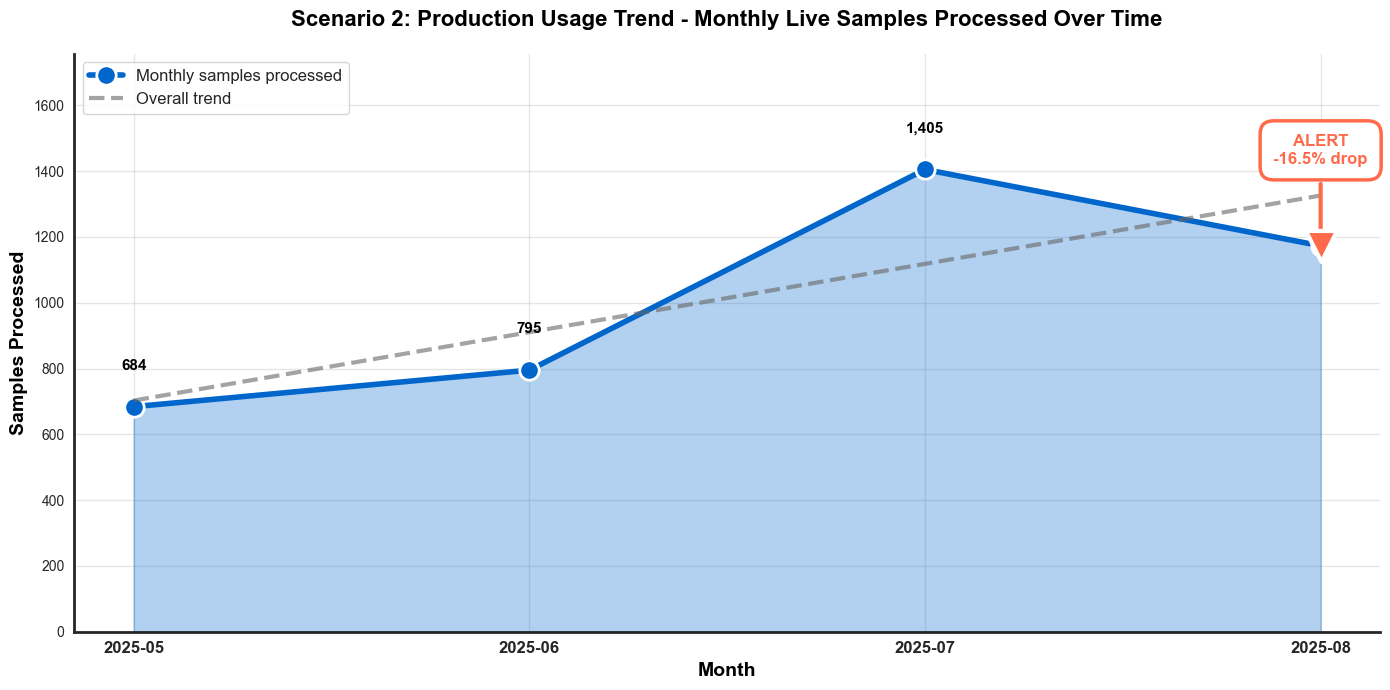

In [159]:
# Scenario 2 - Visual 1: Customer Usage Trend Over Time
# What we're showing: Monthly billable samples with trend line, highlighting significant drops
# Why: Shows overall growth trajectory and identifies concerning drops that exceed risk threshold

if 'usage_live' not in locals() or usage_live.empty:
    print("Run Scenario 2 analysis cell first to create usage_live.")
else:
    visual1_usage_trend(usage_live)

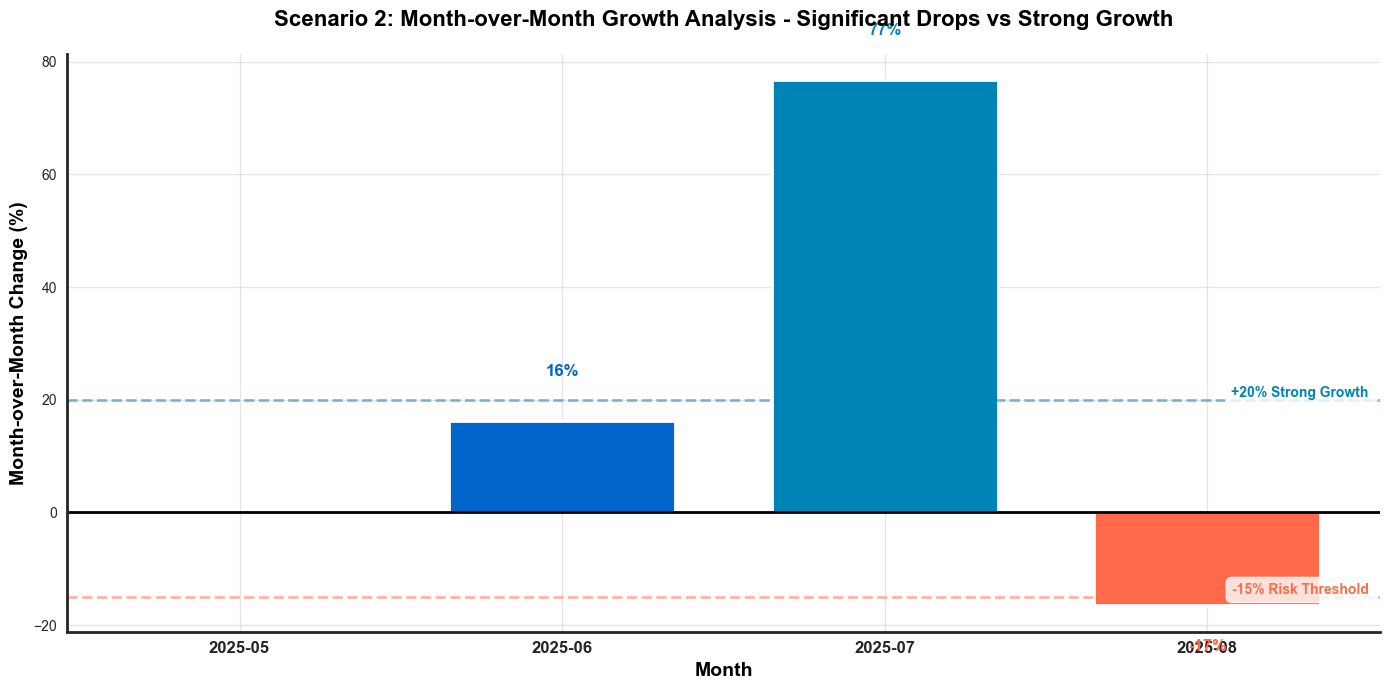

In [160]:
# Scenario 2 - Visual 2: Month-over-Month Growth Rate
# What we're showing: Month-over-month percentage change in billable samples
# Why: Highlights significant drops and growth periods to identify trends

if 'usage_live' not in locals() or usage_live.empty:
    print("Run previous cells first.")
else:
    visual2_mom_growth(usage_live)

## Scenario 2 - Deeper Trend Analysis

**What we're analyzing:** Comprehensive usage patterns using workflow timestamps and run times

**Why:** To better understand customer usage trends beyond simple monthly counts

**Key Analyses:**
- Workflow creation trends over time
- Run duration patterns
- Daily usage timeline
- Weekly operational cycles



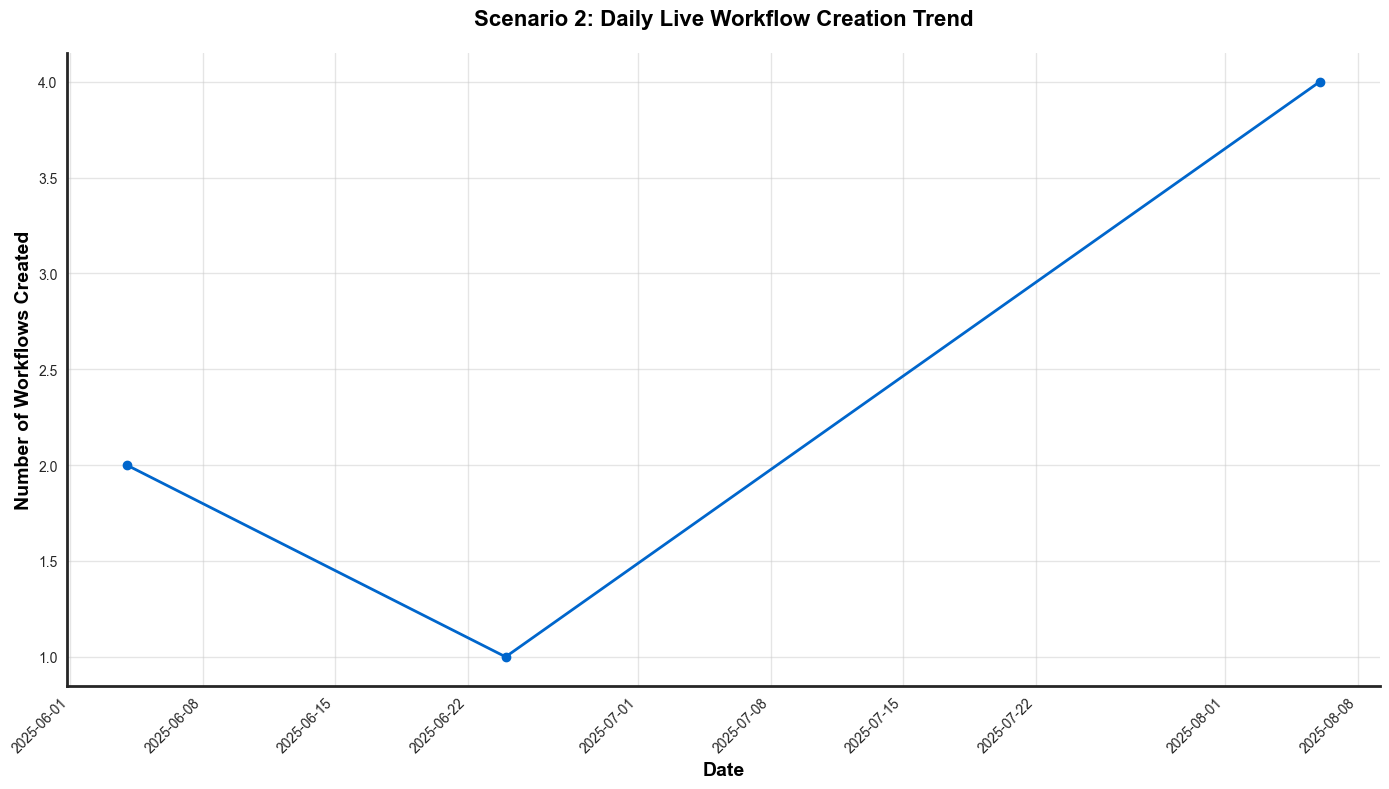

In [161]:
# Scenario 2 - Visual 5: Workflow Creation Trends
# What we're showing: When live workflows were created over time
# Why: Identifies if new workflows correlate with usage changes

if 'df_wfs' not in locals() or df_wfs.empty or 'df_runs' not in locals() or df_runs.empty:
    print("Run data loading cells first.")
else:
    visual5_workflow_creation_trends(df_wfs, df_runs)



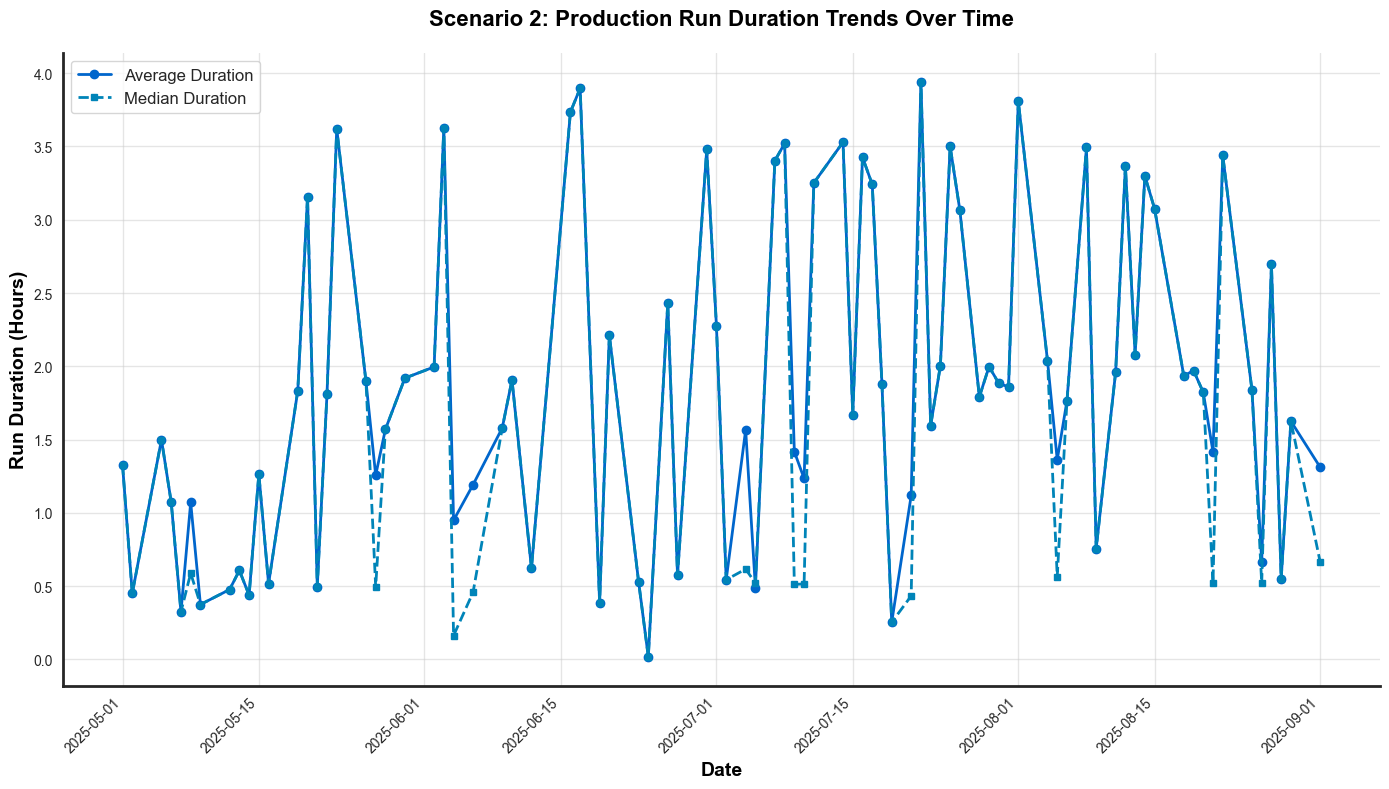

In [162]:
# Scenario 2 - Visual 6: Run Duration Analysis
# What we're showing: How long runs take over time
# Why: Longer run times might indicate operational issues affecting usage

if 'df_runs' not in locals() or df_runs.empty:
    print("Run data loading cells first.")
else:
    visual6_run_duration_analysis(df_runs)



## Scenario 2 - Real-World Customer Health Metrics

**What we're analyzing:** Real-world metrics used in customer success and account management

**Key Metrics:**
- Churn Risk Indicators (consecutive declines, trend analysis)
- Engagement Metrics (workflow utilization, diversity)
- Growth Velocity (acceleration/deceleration)
- Operational Health (success rates, error patterns)
- Usage Concentration (dependency on specific workflows)
- Platform Maturity (new vs established workflows)



In [163]:
# Scenario 2 - Real-World Customer Health Metrics
# What we're doing: Calculating comprehensive customer health metrics
# Why: Provides actionable insights using industry-standard customer success metrics

print("=" * 80)
print("REAL-WORLD CUSTOMER HEALTH METRICS")
print("=" * 80)

if 'usage_live' not in locals() or usage_live.empty:
    print("Run Scenario 2 analysis cell first to create usage_live.")
else:
    # Calculate comprehensive health metrics
    health_metrics = calculate_customer_health_metrics(usage_live, df_runs, df_wfs)
    
    print("\n1. CHURN RISK INDICATORS:")
    print("-" * 80)
    churn = health_metrics['churn_risk']
    print(f"  Risk Level: {churn['risk_level']}")
    print(f"  Consecutive Monthly Declines: {churn['consecutive_monthly_declines']}")
    print(f"  Latest MoM Change: {churn['latest_mom_change']:.2f}%")
    
    print("\n2. ENGAGEMENT METRICS:")
    print("-" * 80)
    engagement = health_metrics['engagement']
    print(f"  Active Workflows: {engagement['active_workflows']} / {engagement['total_workflows']}")
    print(f"  Workflow Utilization: {engagement['workflow_utilization_pct']:.1f}%")
    print(f"  Workflow Diversity Index: {engagement['workflow_diversity_index']:.3f} (0-1, higher = more diverse)")
    
    print("\n3. GROWTH VELOCITY:")
    print("-" * 80)
    growth = health_metrics['growth']
    print(f"  Recent Growth: {growth['recent_growth_pct']:+.2f}%" if growth['recent_growth_pct'] else "  Recent Growth: N/A")
    print(f"  Overall Growth: {growth['overall_growth_pct']:+.2f}%" if growth['overall_growth_pct'] else "  Overall Growth: N/A")
    print(f"  Growth Trajectory: {growth['growth_trajectory']}")
    
    print("\n4. OPERATIONAL HEALTH:")
    print("-" * 80)
    op_health = health_metrics['operational_health']
    print(f"  Latest Success Rate: {op_health['latest_success_rate']:.1f}%" if op_health['latest_success_rate'] else "  Latest Success Rate: N/A")
    print(f"  Average Success Rate: {op_health['avg_success_rate']:.1f}%")
    print(f"  Operational Status: {op_health['operational_status']}")
    
    print("\n5. USAGE CONCENTRATION:")
    print("-" * 80)
    concentration = health_metrics['concentration']
    print(f"  Top Workflow: {concentration['top_workflow_pct']:.1f}% of total usage")
    print(f"  Top 3 Workflows: {concentration['top_3_workflows_pct']:.1f}% of total usage")
    print(f"  Concentration Risk: {concentration['concentration_risk']}")
    
    print("\n6. PLATFORM MATURITY:")
    print("-" * 80)
    maturity = health_metrics['maturity']
    print(f"  Average Workflow Age: {maturity['avg_workflow_age_days']:.0f} days" if maturity['avg_workflow_age_days'] else "  Average Workflow Age: N/A")
    print(f"  New Workflows (<30 days): {maturity['new_workflows_count']}")
    print(f"  Established Workflows: {maturity['established_workflows_count']}")
    print(f"  Maturity Level: {maturity['maturity_level']}")



REAL-WORLD CUSTOMER HEALTH METRICS

1. CHURN RISK INDICATORS:
--------------------------------------------------------------------------------
  Risk Level: MEDIUM
  Consecutive Monthly Declines: 0
  Latest MoM Change: -16.51%

2. ENGAGEMENT METRICS:
--------------------------------------------------------------------------------
  Active Workflows: 9 / 7
  Workflow Utilization: 128.6%
  Workflow Diversity Index: 0.715 (0-1, higher = more diverse)

3. GROWTH VELOCITY:
--------------------------------------------------------------------------------
  Recent Growth: -16.51%
  Overall Growth: +71.49%
  Growth Trajectory: DECELERATING

4. OPERATIONAL HEALTH:
--------------------------------------------------------------------------------
  Latest Success Rate: 75.0%
  Average Success Rate: 62.0%
  Operational Status: CRITICAL

5. USAGE CONCENTRATION:
--------------------------------------------------------------------------------
  Top Workflow: 41.9% of total usage
  Top 3 Workflows: 87.4

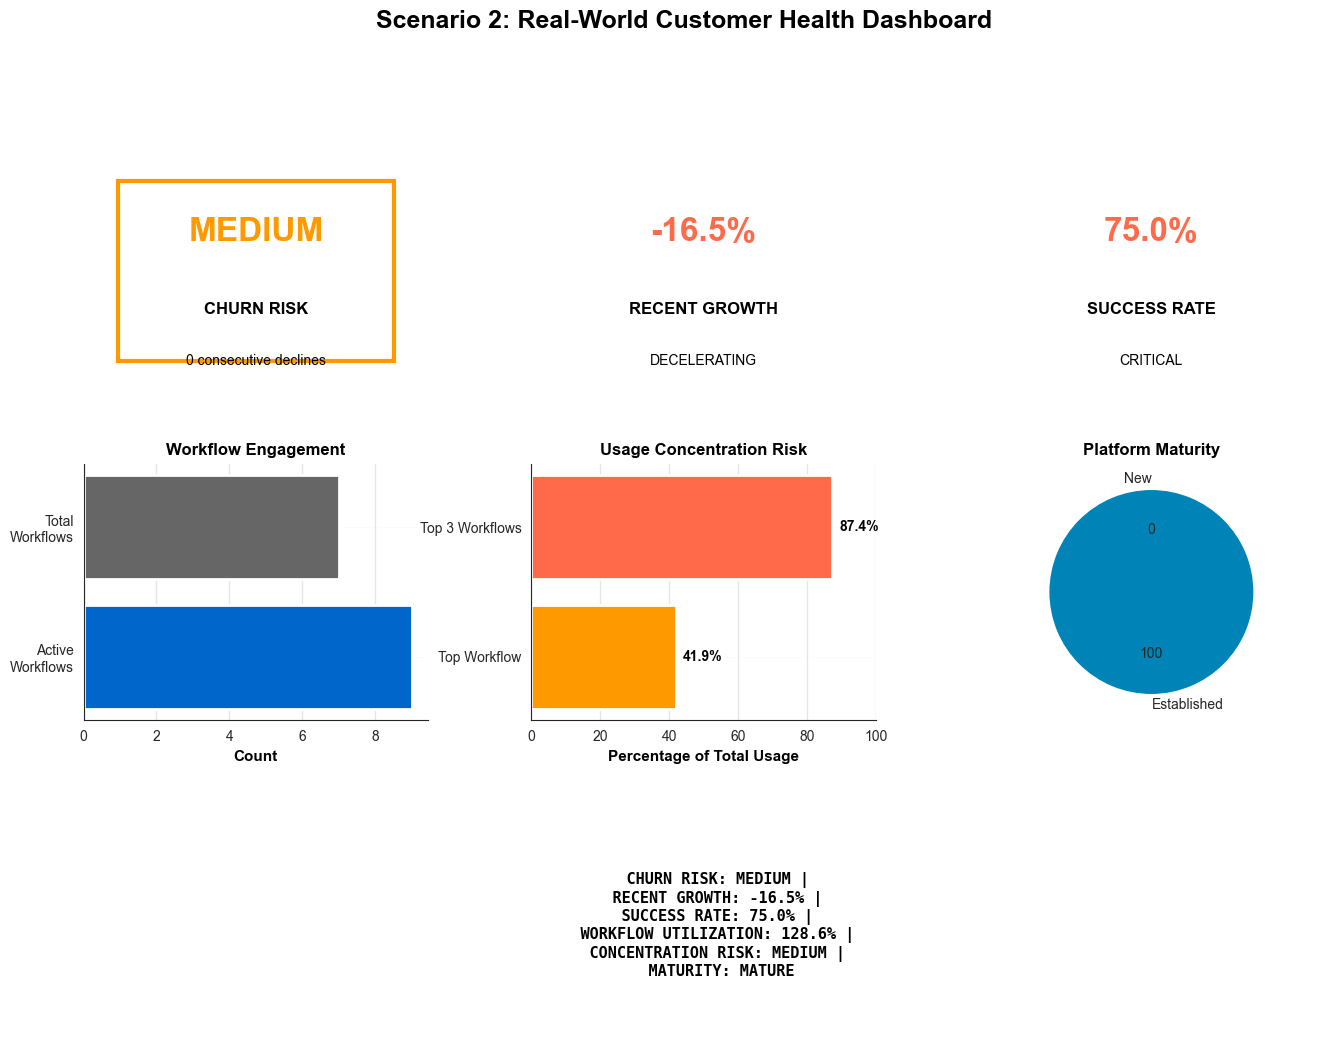

In [164]:
# Scenario 2 - Visual 9: Customer Health Dashboard
# What we're showing: Comprehensive real-world customer health dashboard
# Why: Provides actionable insights using industry-standard customer success metrics

if 'health_metrics' not in locals():
    print("Run the real-world metrics calculation cell first.")
else:
    visual9_customer_health_dashboard(health_metrics)



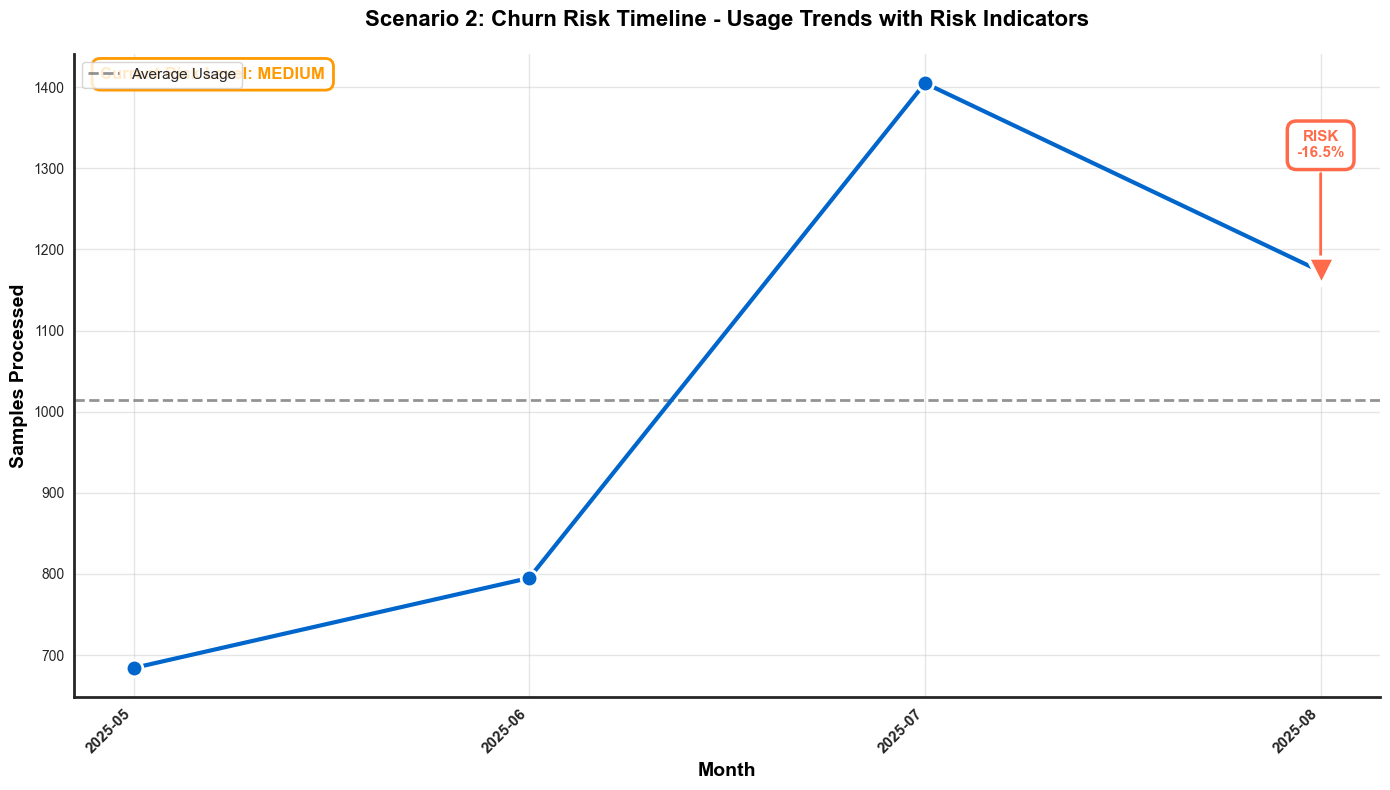

In [165]:
# Scenario 2 - Visual 10: Churn Risk Timeline
# What we're showing: Usage trends with churn risk indicators
# Why: Visualizes churn risk over time to identify concerning patterns

if 'health_metrics' not in locals() or 'usage_live' not in locals() or usage_live.empty:
    print("Run the real-world metrics calculation cell first.")
else:
    visual10_churn_risk_timeline(usage_live, health_metrics)



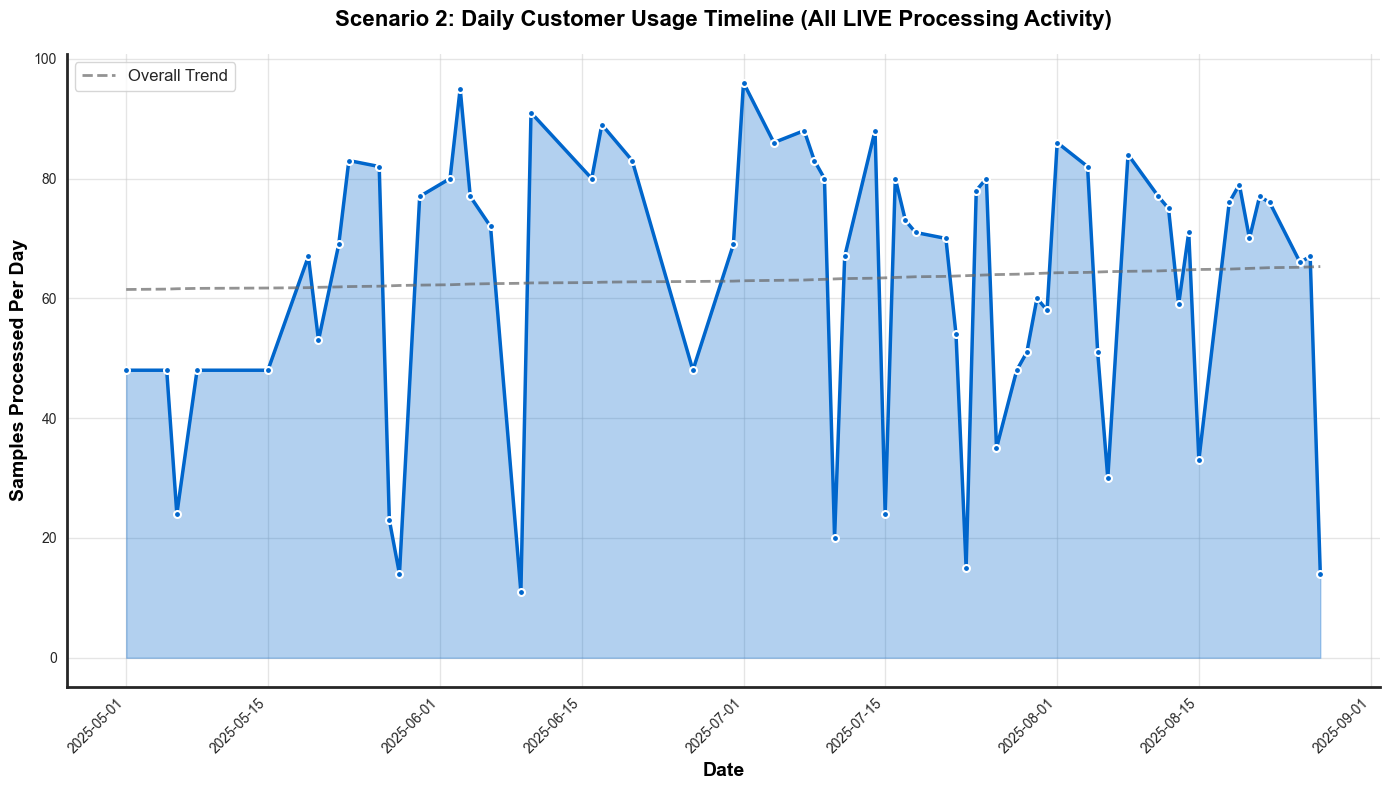

In [166]:
# Scenario 2 - Visual 7: Daily Usage Timeline (All LIVE Processing)
# What we're showing: Daily usage patterns using all samples in LIVE runs
# Why: Shows actual customer usage regardless of QC outcome

if 'checks_live_success' not in locals() or checks_live_success.empty:
    print("Run Scenario 1 cell first to create checks_live_success.")
else:
    visual7_daily_usage_timeline(checks_live_success)



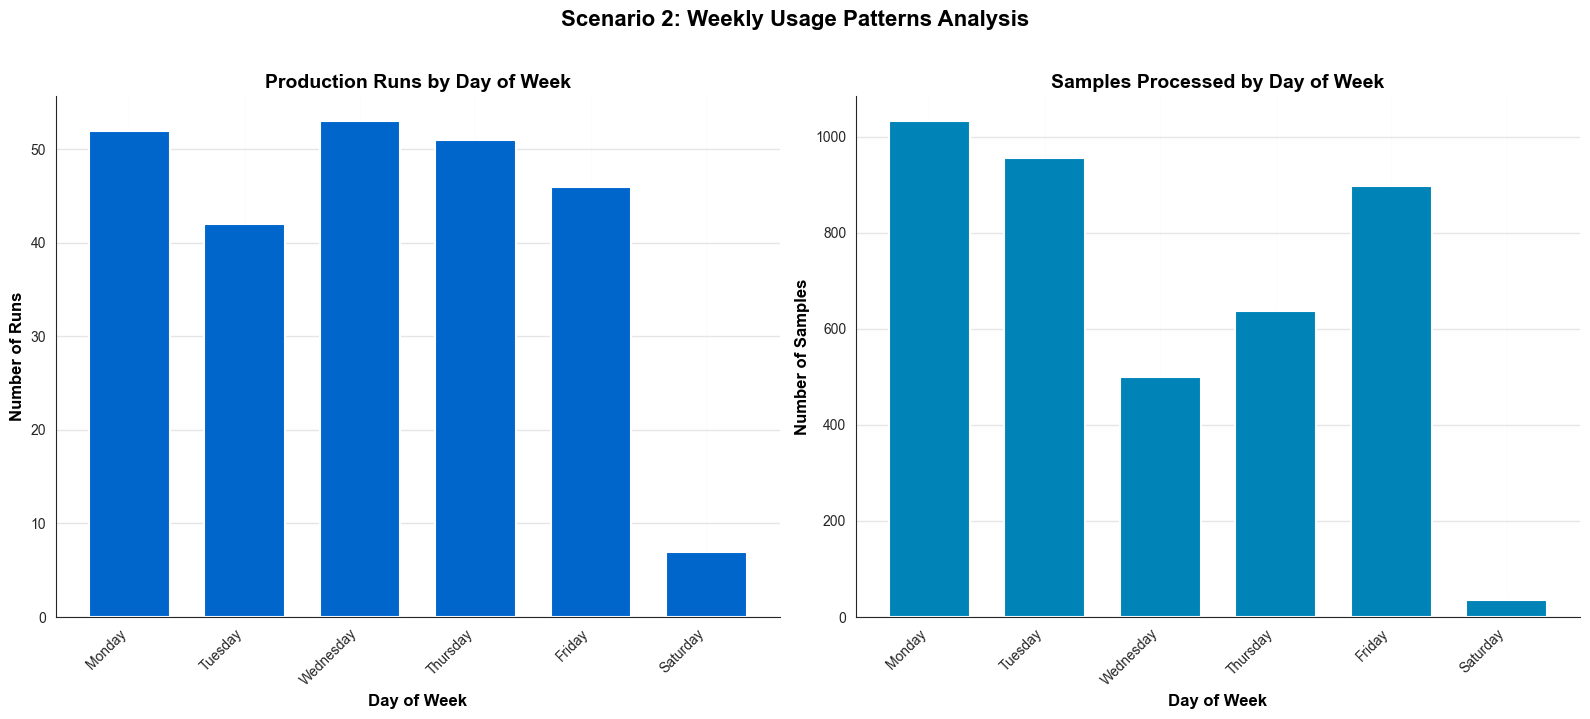

In [167]:
# Scenario 2 - Visual 8: Weekly Usage Patterns
# What we're showing: Usage patterns by day of week
# Why: Identifies weekly operational cycles and business patterns

if 'df_runs' not in locals() or df_runs.empty or 'checks_live_success' not in locals() or checks_live_success.empty:
    print("Run Scenario 1 cell first.")
else:
    visual8_weekly_patterns(df_runs, checks_live_success)



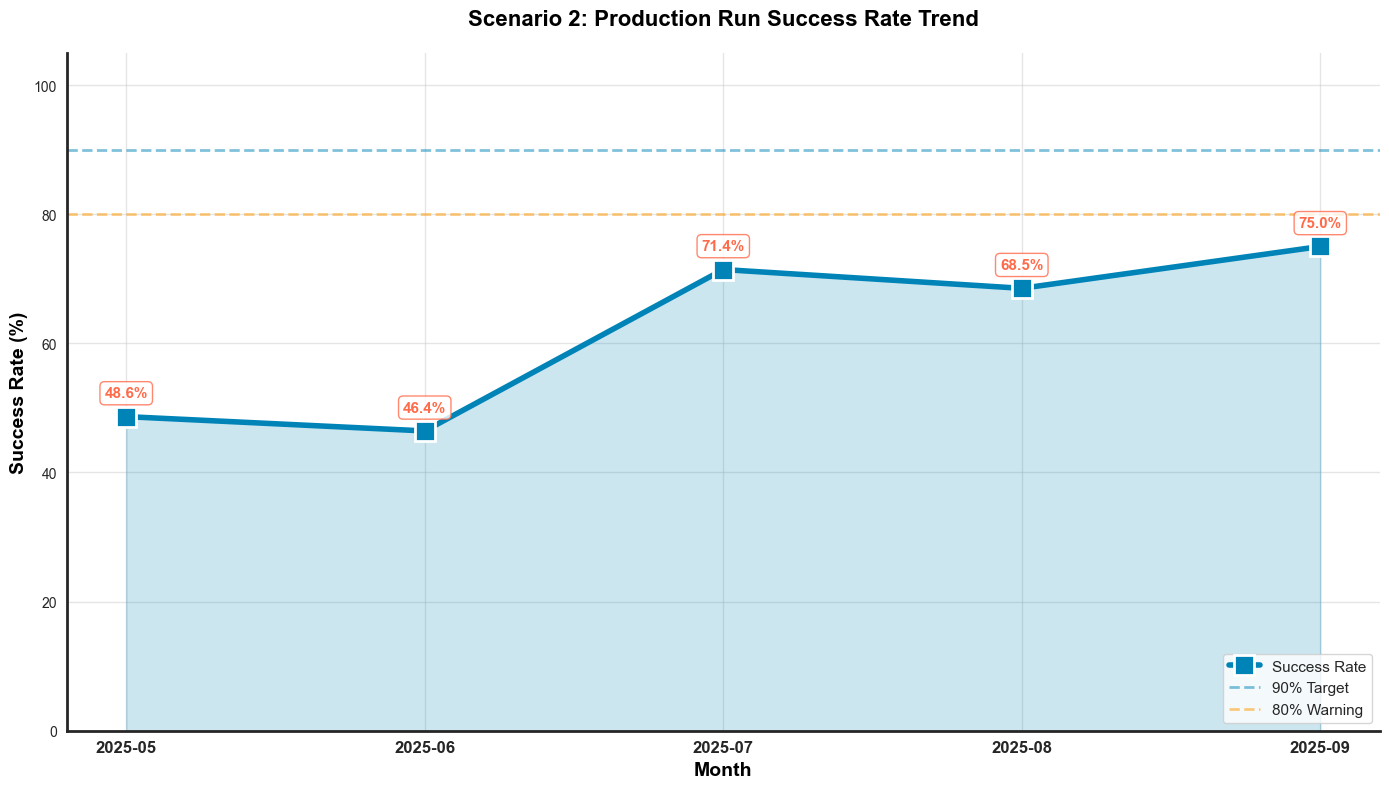

In [168]:
# Scenario 2 - Visual 3: Production Run Success Rate
# What we're showing: Success rate trend over time and breakdown of run outcomes
# Why: Operational quality is a key indicator of customer satisfaction and risk

if 'df_runs' not in locals() or df_runs.empty:
    print("Run previous cells first.")
else:
    visual3_success_rate(df_runs)


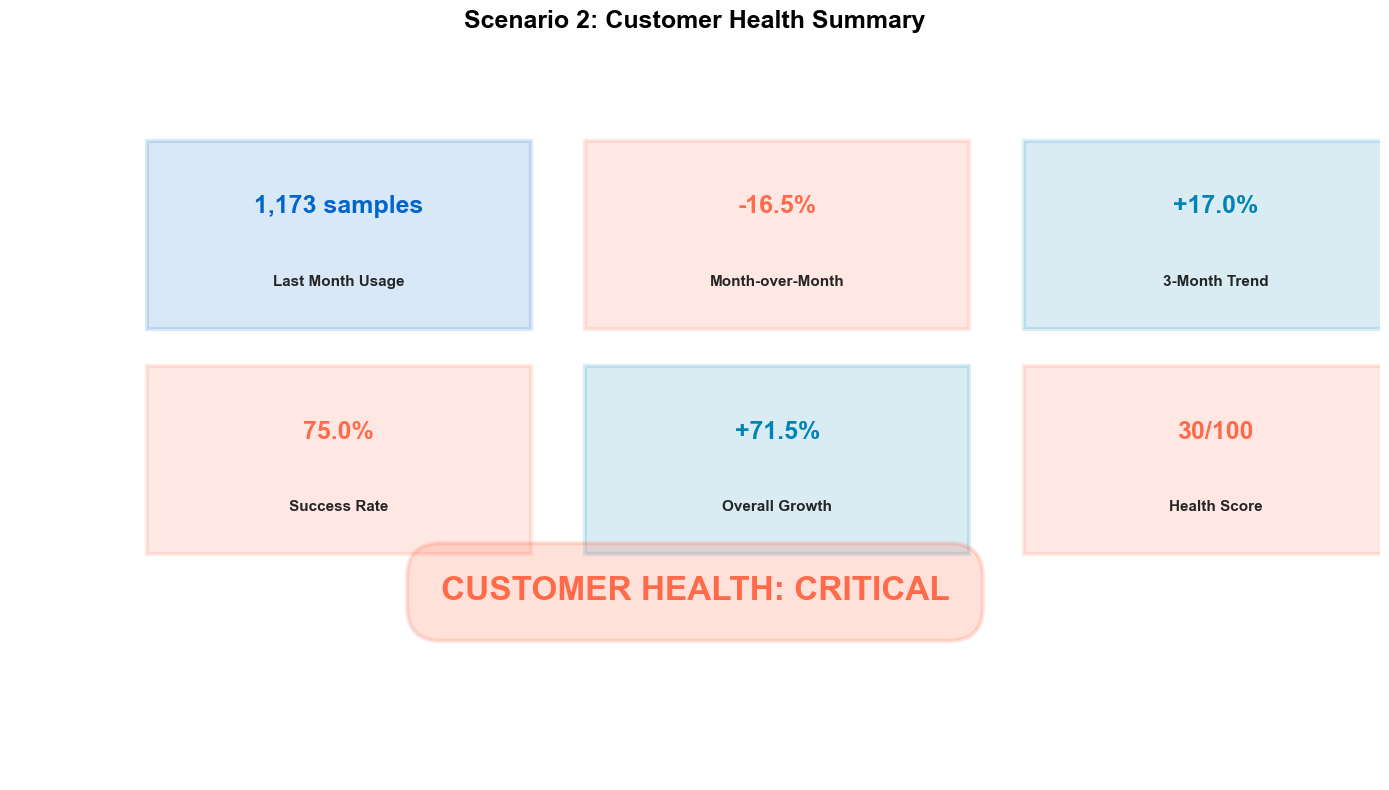

In [169]:
# Scenario 2 - Visual 4: Customer Health Scorecard
# What we're showing: Comprehensive health score combining usage, growth, and quality metrics
# Why: Provides an at-a-glance assessment of overall customer health and risk level

if 'usage_live' not in locals() or usage_live.empty:
    print("Run previous cells first.")
else:
    visual4_health_summary(usage_live, df_runs)